In [1]:
%load_ext autoreload
%autoreload 2

In [34]:
from aps_ai.beamline34IDC.simulation.facade.focusing_optics_interface import Movement

import aps_ai
from aps_ai.beamline34IDC.simulation.facade import Implementors
from aps_ai.beamline34IDC.facade.focusing_optics_factory import focusing_optics_factory_method, ExecutionMode
from aps_ai.beamline34IDC.facade.focusing_optics_interface import Movement, AngularUnits, DistanceUnits
from aps_ai.beamline34IDC.simulation.facade.focusing_optics_interface import get_default_input_features
from aps_ai.common.util.shadow.common import plot_shadow_beam_spatial_distribution, get_shadow_beam_spatial_distribution, \
    load_shadow_beam, PreProcessorFiles, EmptyBeamException
import aps_ai.beamline34IDC.optimization.movers as movers
import aps_ai.beamline34IDC.optimization.common as opt_common
import aps_ai.beamline34IDC.optimization.configs as configs
from aps_ai.common.util import clean_up
from aps_ai.common.util.wrappers import PlotMode


from Shadow.ShadowTools import focnew
from pathlib import Path

import os
import matplotlib.pyplot as plt
import numpy as np
import scipy
from tqdm import tqdm
import shutil
import IPython
from skopt.callbacks import DeltaXStopper, DeltaYStopper, DeadlineStopper
from pathlib import Path
import optuna
from test_optuna_qnehvi import BoTorchSampler, qnehvi_candidates_func

%matplotlib inline


In [4]:
DEFAULT_RANDOM_SEED = np.random.randint(100000)
print(DEFAULT_RANDOM_SEED)

99368


In [5]:
!pwd

/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test


In [6]:
base_dir = Path(aps_ai.__file__).parents[1]
orig_work_dir = base_dir /'work_directory'
temp_work_dir = base_dir / f'tmp_work_dir_{DEFAULT_RANDOM_SEED}'
temp_work_dir.mkdir(exist_ok=True)

In [7]:
dat_files = list(orig_work_dir.glob('*.dat')) + list(orig_work_dir.glob('*.ini'))
for df in dat_files:
    shutil.copy(df, temp_work_dir)

In [8]:
os.chdir(temp_work_dir)

In [9]:
input_beam_path = "primary_optics_system_beam.dat"

In [10]:
move_motors_ranges = {'hkb_1': [-50, 50], 
                      'vkb_1': [-50, 50],
                      'hkb_2': [-50, 50],
                      'vkb_2': [-50, 50],
                      'hkb_3': [-0.04, 0.04],
                      'vkb_3': [-0.04, 0.04],
                      'hkb_4': [-30, 30], 
                      'vkb_4': [-30, 30]}

In [11]:
save_figs = False

if save_figs:
    motors_str = move_motors[0] if len(move_motors) == 1 else '_'.join(move_motors)
    fig_save_path = f'{orig_work_dir}/figures/{motors_str}/'
    if not os.path.isdir(fig_save_path):
        os.mkdir(fig_save_path)

In [14]:
# Focusing Optics System -------------------------
focusing_system = opt_common.reinitialize(input_beam_path=input_beam_path, bender=True)
plot_shadow_beam_spatial_distribution(focusing_system.get_photon_beam())

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


In [15]:
initial_absolute_positions = np.array(movers.get_absolute_positions(focusing_system, list(move_motors_ranges.keys())))
print(initial_absolute_positions)

[215.5 144.  112.5 231.5   3.    3.    0.    0. ]


In [16]:
hkb_motors_ranges = {k:v for k, v in move_motors_ranges.items() if 'hkb' in k}

In [17]:
vkb_motors_ranges = {k:v for k, v in move_motors_ranges.items() if 'vkb' in k}

In [18]:
class OptunaOptimizer(opt_common.OptimizationCommon):
    """"""
    opt_platform = 'optuna'

    
    #def motor_subset_loss_function(self, motor_types: list, verbose: bool = True):
    #    lossfn_object_this = self.TrialInstanceLossFunction(self, verbose=verbose)
    #    
    #    translations_all = np.zeros(len(self.motor_types))
    #    
    #    def closure_fn(translations):
    #        for ix, motor in enumerate(motor_types):
    #            iy = self.motor_types.index(motor)
    #            translations_all[iy] = translations[ix]
    #        
    #        return lossfn_object_this.loss(translations_all)
    #    return closure_fn
    
    def set_optimizer_options(self, motor_ranges: list=None, 
                              base_sampler: optuna.samplers.BaseSampler = None, 
                              directions: str = None, 
                              integral_threshold: float = 1e2,
                              raise_prune_exception: bool = True,
                              **extra_options):
        
        self.motor_ranges = self._get_guess_ranges(motor_ranges)
        
        if base_sampler is None:
            #if self.multi_objective_optimization:
            #    base_sampler = optuna.samplers.MOTPESampler()
            #else:
            base_sampler = optuna.samplers.TPESampler()
        self._base_sampler = base_sampler
        self._raise_prune_exception = raise_prune_exception
        
        if directions is None:
            directions = ['minimize'] * len(self._loss_function_list)
        elif len(directions) != len(self._loss_function_list):
            raise ValueError
        self._directions = directions
        
        self.study = optuna.create_study(sampler=self._base_sampler, directions=self._directions)
        self.study.enqueue_trial({mt: 0. for mt in self.motor_types})
        
        loss_fn_obj = self.TrialInstanceLossFunction(self, verbose=False)
        self._loss_fn_this = loss_fn_obj.loss
        self.integral_threshold = integral_threshold
        
        self.best_params = {k: 0. for k in self.motor_types}
    
    def _objective(self, trial):
        current_params = []
        for mot, r in zip(self.motor_types, self.motor_ranges):
            resolution = configs.DEFAULT_MOTOR_RESOLUTIONS[mot]
            #print(mot, 'Min, max, resolution', r[0], r[1], resolution)
            current_params.append(trial.suggest_float(mot, r[0], r[1], step=resolution))
        loss = self._loss_fn_this(current_params)
        if self.multi_objective_optimization:
            if np.nan in loss and self._raise_prune_exception:
                raise optuna.TrialPruned
            loss[np.isnan(loss)] = 1e4
            
            if self.integral_threshold is not None:
                if self.beam_state.hist.data_2D.sum() < self.integral_threshold:
                    if self._raise_prune_exception:
                        raise optuna.TrialPruned
                    else:
                        return [1e4] * len(self._loss_function_list)
                    
            
            for k in ['sigma', 'fwhm']:
                if k in self.loss_parameters:
                    width_idx = self.loss_parameters.index(k)
                    if loss[width_idx] == 0: loss[width_idx] = 1e4
            loss = list(loss)
        

        rads = (self.beam_state.hist.hh**2 + self.beam_state.hist.vv**2)**0.5
        weighted_sum_ints = np.sum(self.beam_state.hist.data_2D * rads)
        trial.set_user_attr("wsum", weighted_sum_ints)
            
        return loss
    
    def trials(self, n_trials: int, trial_motor_types: list = None):
        if trial_motor_types is None:
            self.study.optimize(self._objective, n_trials)
            
        else:
            
            fixed_params = {k: self.best_params[k] for k in self.best_params if k not in trial_motor_types}
            partial_sampler = optuna.samplers.PartialFixedSampler(fixed_params, self._base_sampler)
            
            self.study.sampler = partial_sampler
            self.study.optimize(self._objective, n_trials=n_trials)
            
            self.study.sampler = self._base_sampler
        
        self.best_params.update(self.study.best_trials[0].params)
    
    #def trials(self, n_guesses = 1, verbose: bool = False, accept_all_solutions: bool = False):
    #    pass
    
    def _optimize(self):
        pass

    #def set_optimizer_options(self):
    #    pass
    

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


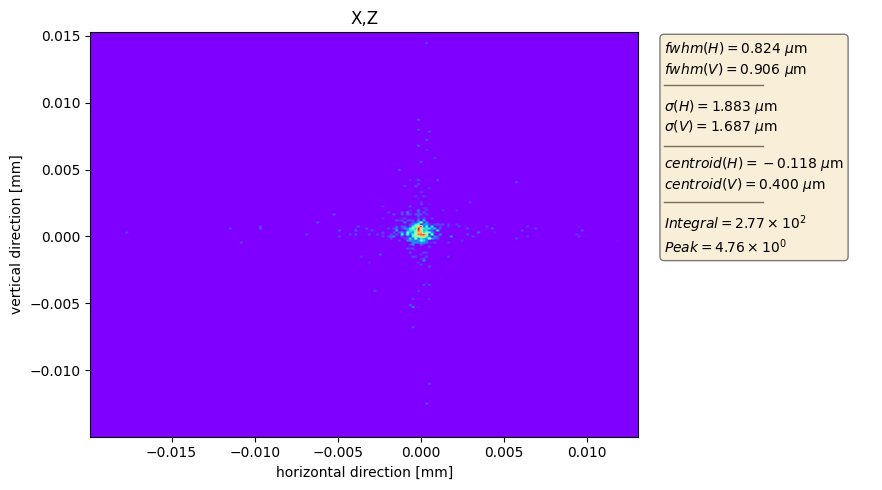

In [24]:
focusing_system = opt_common.reinitialize(input_beam_path=input_beam_path, bender=True)
beam, hist, dw = opt_common.get_beam_hist_dw(focusing_system)
plot_shadow_beam_spatial_distribution(beam)

In [25]:
centroid_ground, *_ = opt_common.get_centroid_distance(photon_beam=beam, random_seed=DEFAULT_RANDOM_SEED)
sigma_ground, *_ = opt_common.get_sigma(photon_beam=beam)
centroid_ground, sigma_ground

(0.0004134023056922426, 0.0025289989338900926)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.
Random initialization is ['hkb_1', 'vkb_1', 'hkb_2', 'vkb_2', 'hkb_3', 'vk

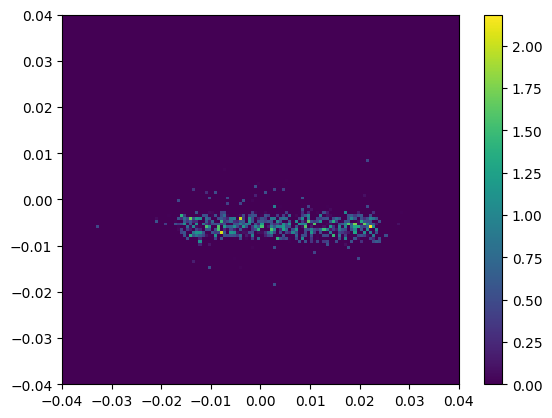

In [26]:
initial_movement, focusing_system, beam, hist, dw = opt_common.get_random_init(focusing_system, motor_types=list(move_motors_ranges.keys()),
                                                                               init_range=list(move_motors_ranges.values()),
                                                                               xrange=[-0.04, 0.04],yrange=[-0.04,0.04], 
                                                                               integral_threshold=100,
                                                                               nbins=128)
plt.pcolormesh(hist.vv, hist.hh, hist.data_2D.T)
plt.colorbar()
plt.show()

In [27]:
hist.data_2D.sum()

260.4704788545897

In [28]:
focusing_system = movers.move_motors(focusing_system, list(move_motors_ranges.keys()), initial_absolute_positions + initial_movement, movement='absolute')

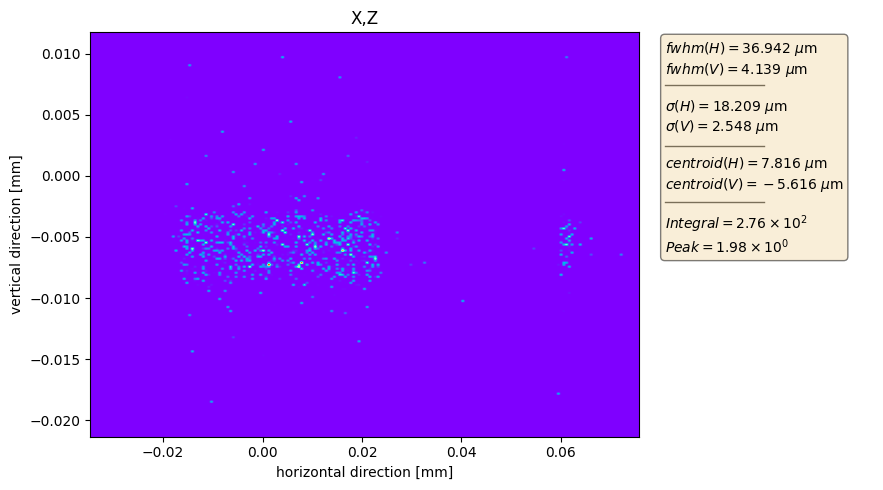

In [29]:
beam = opt_common.get_beam(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
plot_shadow_beam_spatial_distribution(beam)

In [30]:

opt_trial = OptunaOptimizer(focusing_system, 
                            motor_types=list(move_motors_ranges.keys()), 
                            random_seed=DEFAULT_RANDOM_SEED, 
                            loss_parameters=['centroid', 'sigma'],
                            loss_min_value=5e-4,
                            use_gaussian_fit=False,
                            multi_objective_optimization=True,
                            camera_xrange=[-0.03, 0.03],
                            camera_yrange=[-0.03, 0.03],
                            camera_nbins=512)
#opt_trial.motor_ranges = centroid_ranges

opt_trial.reset()

In [31]:
#base_sampler = optuna.integration.BoTorchSampler()
base_sampler = BoTorchSampler(candidates_func=qnehvi_candidates_func, acq_func_kwargs={'ref_point':[-1e-3,-5e-3]})

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_78784/2930600393.py:2: ExperimentalWarning: BoTorchSampler is experimental (supported from v2.4.0). The interface can change in the future.
  base_sampler = BoTorchSampler(candidates_func=qnehvi_candidates_func, acq_func_kwargs={'ref_point':[-1e-3,-5e-3]})


In [32]:

# Pruning too manu values. For now, setting values to 1e4 instead of pruning
opt_trial.set_optimizer_options(motor_ranges=list(move_motors_ranges.values()), integral_threshold=100, base_sampler=base_sampler,
                                raise_prune_exception=True)

[I 2022-10-06 00:13:57,584] A new study created in memory with name: no-name-6943063e-c47d-497a-8435-1f71503018f2


In [35]:
opt_trial.trials(100, trial_motor_types=['hkb_4', 'vkb_4', 'hkb_3', 'vkb_3'])

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_78784/3771019275.py:91: ExperimentalWarning: PartialFixedSampler is experimental (supported from v2.4.0). The interface can change in the future.
  partial_sampler = optuna.samplers.PartialFixedSampler(fixed_params, self._base_sampler)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-0.04, 0.038539816339744834].
  warnings.warn(
[I 2022-10-06 00:14:24,470] Trial 1 

In [36]:
opt_trial.study.best_trials

[FrozenTrial(number=42, values=[0.0009002034228487802, 0.00408315227473025], datetime_start=datetime.datetime(2022, 10, 6, 0, 15, 14, 410485), datetime_complete=datetime.datetime(2022, 10, 6, 0, 15, 16, 931380), params={'hkb_1': 0.0, 'vkb_1': 0.0, 'hkb_2': 0.0, 'vkb_2': 0.0, 'hkb_3': -0.012074731968090727, 'vkb_3': 0.001887902047863911, 'hkb_4': 16.900000000000006, 'vkb_4': 4.100000000000001}, distributions={'hkb_1': FloatDistribution(high=49.99999999999999, log=False, low=-50.0, step=9.999999999999999e-05), 'vkb_1': FloatDistribution(high=49.99999999999999, log=False, low=-50.0, step=9.999999999999999e-05), 'hkb_2': FloatDistribution(high=49.99999999999999, log=False, low=-50.0, step=9.999999999999999e-05), 'vkb_2': FloatDistribution(high=49.99999999999999, log=False, low=-50.0, step=9.999999999999999e-05), 'hkb_3': FloatDistribution(high=0.038539816339744834, log=False, low=-0.04, step=0.0017453292519943296), 'vkb_3': FloatDistribution(high=0.038539816339744834, log=False, low=-0.04,

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_78784/1036378160.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


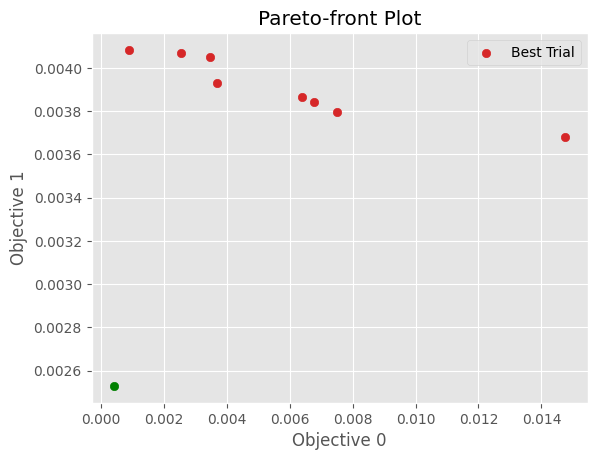

In [37]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
plt.scatter(centroid_ground, sigma_ground, color='green')

In [38]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum(), t.user_attrs['wsum'])

-12.513775767317304 0.7657919836063362
-11.17398059924427 1.4521917253451493
-10.466587899163976 2.6996143785666944
-10.609438633177287 1.2476789820609735
-10.557627206528139 1.2762354728014949
-11.1402082021418 0.9536281520546777
-9.82063348138939 2.295070150633998
-11.474780285977168 0.9567623330365678


[0.0009002034228487802, 0.00408315227473025] 0.7657919836063362


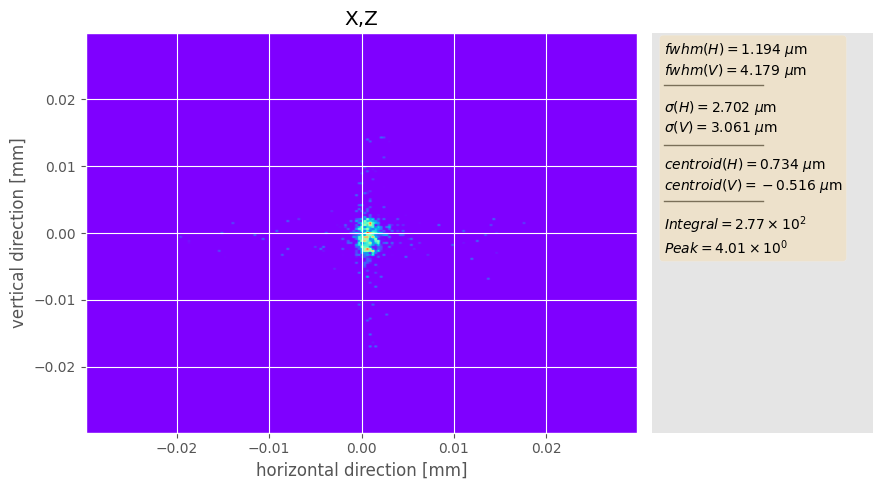

[0.0034640928522502758, 0.004051467509281132] 1.4521917253451493


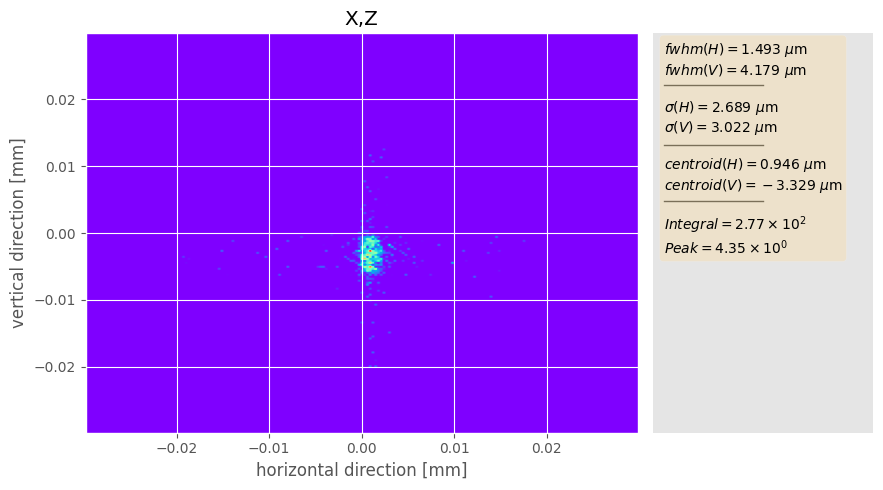

[0.007498395943419271, 0.0037970844997331876] 2.6996143785666944


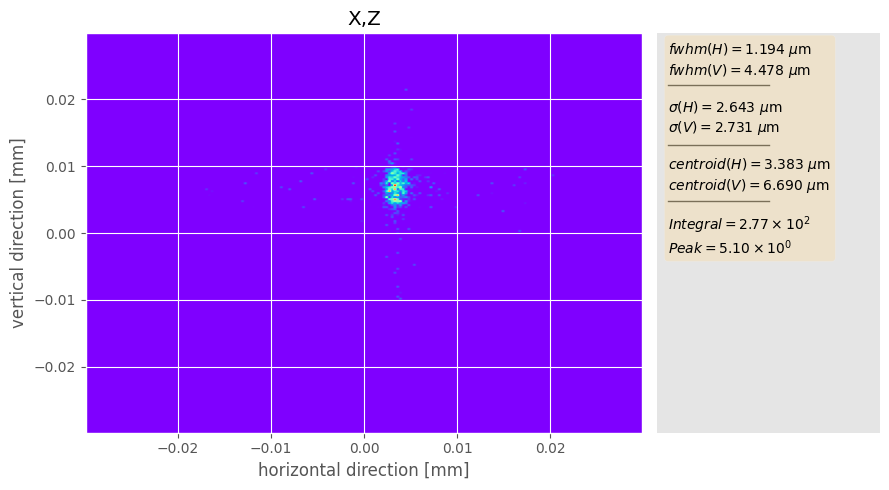

[0.006384506435776498, 0.003865912467356664] 1.2476789820609735


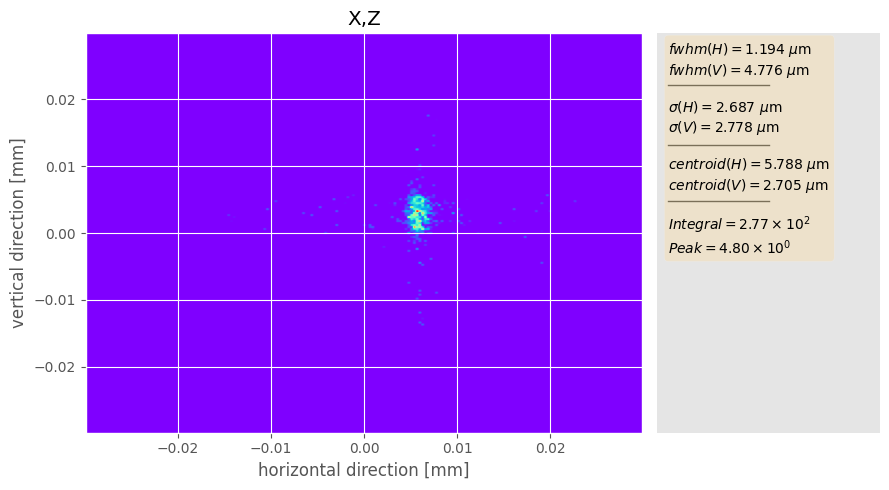

[0.006769191324011386, 0.003840112724745026] 1.2762354728014949


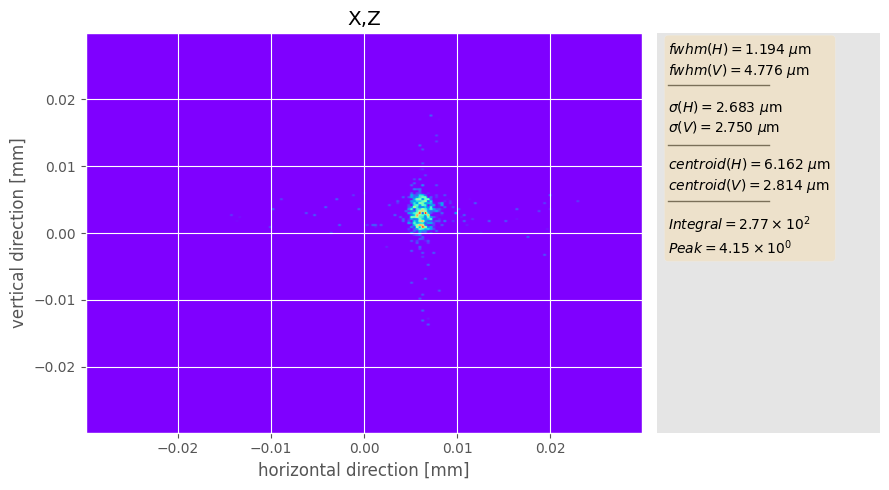

[0.0036953903037940327, 0.00392833698285615] 0.9536281520546777


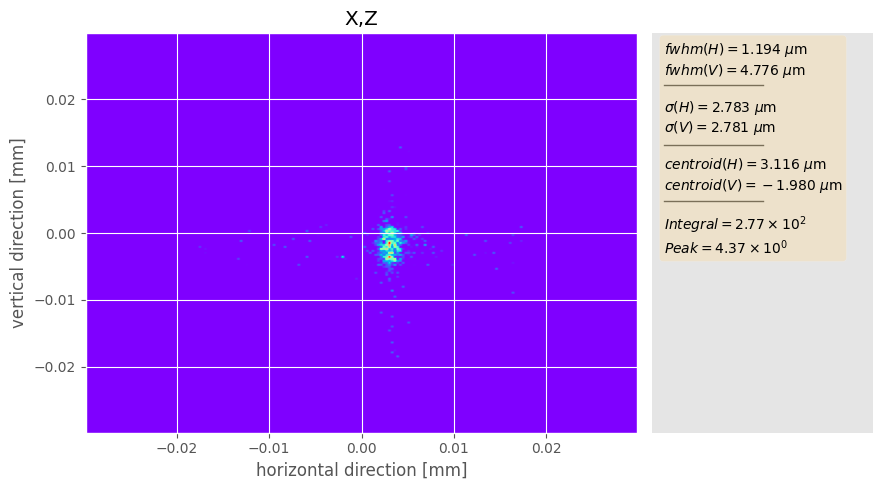

[0.014750459598336721, 0.0036825403814505996] 2.295070150633998


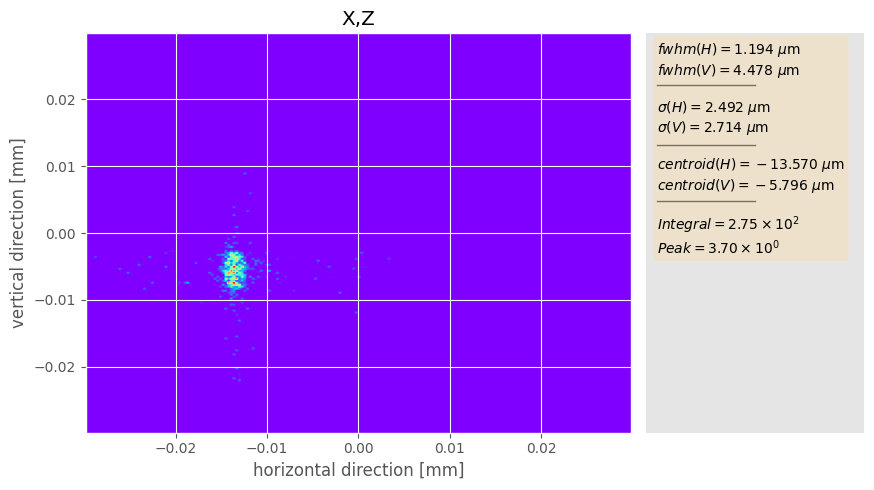

[0.002554643971193791, 0.004066641213000974] 0.9567623330365678


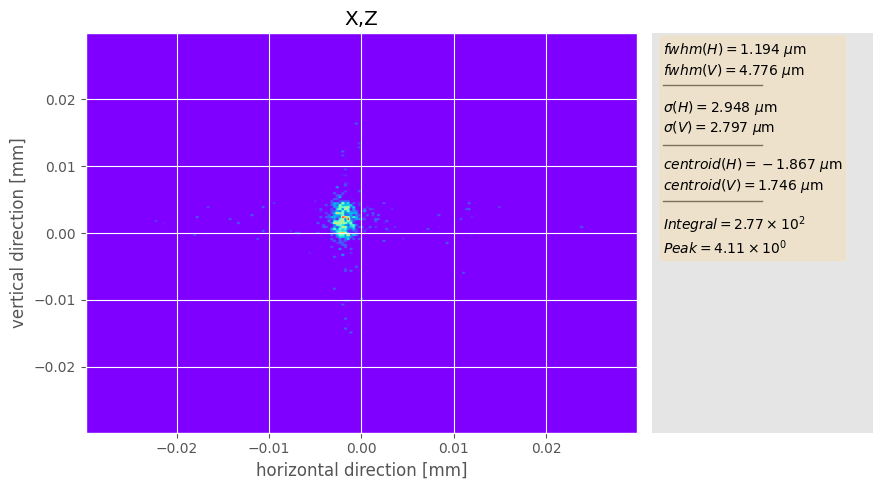

In [39]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values, t.user_attrs['wsum'])
    plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)

In [40]:
opt_trial.trials(100)

/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-0.04, 0.038539816339744834].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:19:13,069] Trial 101 finished with values: [0.0004515694786789889, 0.003769290162987598] and parameters: {'hkb_1': 12.538399999999996, 'vkb_1': -6.316300000000005, 'hkb_2': -2.1888000000000076, 'vkb_2': 5.851499999999994, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 21.0, 'vkb_4': 1.1000000000000014}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:19:17,632] Trial 102 finished with values: [0.0003711685439727295, 0.00413686547148189] and parameters: {'hkb_1': -0.01190000000000424, 'vkb_1': 0.7939999999999969, 'hkb_2': -23.911500000000004, 'vkb_2': -11.129400000000004, 'hkb_3': 0.02981317007977318, 'vkb_3': 0.010614548307835557, 'hkb_4': 27.200000000000003, 'vkb_4': 0.5}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:19:21,166] Trial 103 finished with values: [0.0007777891963224601, 0.003899643550740508] and parameters: {'hkb_1': 15.456800000000001, 'vkb_1': -3.7554000000000016, 'hkb_2': -16.581300000000006, 'vkb_2': -5.205300000000001, 'hkb_3': 0.015850536063818546, 'vkb_3': 0.008869219055841225, 'hkb_4': 23.900000000000006, 'vkb_4': 1.0}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:19:25,189] Trial 104 finished with values: [0.0007425701744644466, 0.00395813418795734] and parameters: {'hkb_1': 3.0267999999999944, 'vkb_1': -8.369300000000003, 'hkb_2': -20.179000000000002, 'vkb_2': 6.651999999999994, 'hkb_3': 0.003633231299858236, 'vkb_3': 0.012359877559829889, 'hkb_4': 21.5, 'vkb_4': 0.10000000000000142}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:19:29,376] Trial 105 finished with values: [0.0006255370816450376, 0.004039262079992359] and parameters: {'hkb_1': 6.376399999999997, 'vkb_1': -15.161100000000005, 'hkb_2': -8.064900000000002, 'vkb_2': -8.235300000000002, 'hkb_3': 0.0001425727958695791, 'vkb_3': 0.010614548307835557, 'hkb_4': 20.6, 'vkb_4': 0.7000000000000028}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:19:33,093] Trial 106 finished with values: [0.007959455108715693, 0.004144676105891098] and parameters: {'hkb_1': 30.447699999999998, 'vkb_1': -4.6921000000000035, 'hkb_2': -18.2584, 'vkb_2': -23.560200000000002, 'hkb_3': 0.015850536063818546, 'vkb_3': -0.003348085708119078, 'hkb_4': 15.900000000000006, 'vkb_4': 4.100000000000001}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.w

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:19:37,235] Trial 107 finished with values: [0.009967379902710504, 0.004378511810156124] and parameters: {'hkb_1': 9.202499999999993, 'vkb_1': -41.3792, 'hkb_2': -19.597500000000004, 'vkb_2': -2.5408000000000044, 'hkb_3': -0.003348085708119078, 'vkb_3': 0.010614548307835557, 'hkb_4': 26.800000000000004, 'vkb_4': 6.899999999999999}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.wa

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:19:41,170] Trial 108 finished with values: [0.00040134389341310036, 0.004115003910574179] and parameters: {'hkb_1': 13.811299999999996, 'vkb_1': -9.245000000000005, 'hkb_2': -13.259400000000007, 'vkb_2': -0.05160000000000764, 'hkb_3': -0.00509341496011341, 'vkb_3': 0.003633231299858236, 'hkb_4': 19.1, 'vkb_4': 4.300000000000004}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.war

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:19:44,558] Trial 109 finished with values: [0.005766781760463945, 0.00408797366871687] and parameters: {'hkb_1': 22.867199999999997, 'vkb_1': -26.840000000000003, 'hkb_2': -37.8434, 'vkb_2': 28.983799999999988, 'hkb_3': 0.008869219055841225, 'vkb_3': 0.003633231299858236, 'hkb_4': 26.6, 'vkb_4': 2.6000000000000014}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applicatio

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:19:48,670] Trial 110 finished with values: [0.00200171955816229, 0.004663417932523802] and parameters: {'hkb_1': -13.956600000000002, 'vkb_1': -13.4452, 'hkb_2': -17.487000000000002, 'vkb_2': -28.7982, 'hkb_3': -0.00509341496011341, 'vkb_3': -0.0016027564561247529, 'hkb_4': 21.0, 'vkb_4': 5.200000000000003}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:19:53,081] Trial 111 finished with values: [0.0029775675084042995, 0.004041022136112276] and parameters: {'hkb_1': 10.039299999999997, 'vkb_1': -38.5325, 'hkb_2': 6.239599999999996, 'vkb_2': 25.04849999999999, 'hkb_3': 0.019341194567807203, 'vkb_3': 0.005378560551852568, 'hkb_4': 22.800000000000004, 'vkb_4': 2.1000000000000014}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:19:57,095] Trial 112 finished with values: [0.00255430312740811, 0.003932861256618394] and parameters: {'hkb_1': 27.200799999999987, 'vkb_1': -22.361700000000003, 'hkb_2': -13.181200000000004, 'vkb_2': 18.393699999999995, 'hkb_3': 0.021086523819801535, 'vkb_3': 0.012359877559829889, 'hkb_4': 24.5, 'vkb_4': -1.5}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:20:01,009] Trial 113 finished with values: [0.007869868280686797, 0.004013376868322209] and parameters: {'hkb_1': 35.373599999999996, 'vkb_1': -7.9373000000000005, 'hkb_2': -24.8211, 'vkb_2': 12.616599999999991, 'hkb_3': 0.02806784082777885, 'vkb_3': 0.0001425727958695791, 'hkb_4': 24.0, 'vkb_4': -1.5}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.a

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:20:04,920] Trial 114 finished with values: [0.010788072397683353, 0.004226528360060137] and parameters: {'hkb_1': -5.9998000000000005, 'vkb_1': -34.5818, 'hkb_2': 11.951399999999992, 'vkb_2': 13.847599999999993, 'hkb_3': -0.026037365984045366, 'vkb_3': 0.008869219055841225, 'hkb_4': 22.800000000000004, 'vkb_4': -3.5}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applicat

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:20:09,237] Trial 115 finished with values: [0.009578192143299153, 0.004194156988528687] and parameters: {'hkb_1': 30.244799999999998, 'vkb_1': -28.372100000000003, 'hkb_2': 26.96069999999999, 'vkb_2': 20.865199999999987, 'hkb_3': -0.006838744212107742, 'vkb_3': 0.001887902047863911, 'hkb_4': 17.700000000000003, 'vkb_4': -3.5}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:20:13,555] Trial 116 finished with values: [0.0019803046206133897, 0.00387872240654411] and parameters: {'hkb_1': 1.6228999999999942, 'vkb_1': -21.901000000000003, 'hkb_2': 10.587199999999996, 'vkb_2': 48.998299999999986, 'hkb_3': -0.012074731968090727, 'vkb_3': 0.014105206811824214, 'hkb_4': 19.400000000000006, 'vkb_4': 1.3000000000000007}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:20:17,893] Trial 117 finished with values: [0.0022857077703551795, 0.003964281457397968] and parameters: {'hkb_1': 33.42869999999999, 'vkb_1': -41.763400000000004, 'hkb_2': -14.800000000000004, 'vkb_2': 33.7307, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.008869219055841225, 'hkb_4': 19.200000000000003, 'vkb_4': 0.8000000000000007}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.wa

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:20:22,420] Trial 118 finished with values: [0.004458685285950482, 0.00416040266385745] and parameters: {'hkb_1': 19.848, 'vkb_1': 48.541, 'hkb_2': -34.6192, 'vkb_2': -16.5835, 'hkb_3': 0.033303828583761845, 'vkb_3': 0.005378560551852568, 'hkb_4': 27.0, 'vkb_4': -2.3999999999999986}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framework

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:20:26,767] Trial 119 finished with values: [0.009589293018694175, 0.004213374361451607] and parameters: {'hkb_1': 33.1468, 'vkb_1': 25.66839999999999, 'hkb_2': -28.674400000000002, 'vkb_2': -21.024, 'hkb_3': 0.02806784082777885, 'vkb_3': 0.010614548307835557, 'hkb_4': 28.900000000000006, 'vkb_4': 8.700000000000003}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applicatio

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:20:31,248] Trial 120 finished with values: [0.0011072445019276633, 0.003344697925029193] and parameters: {'hkb_1': 45.22239999999999, 'vkb_1': 7.453799999999994, 'hkb_2': 5.251899999999992, 'vkb_2': 25.37039999999999, 'hkb_3': 0.015850536063818546, 'vkb_3': 0.008869219055841225, 'hkb_4': 22.5, 'vkb_4': 2.5}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:20:34,823] Trial 121 finished with values: [0.004426013664619089, 0.003589043841956229] and parameters: {'hkb_1': 24.778499999999994, 'vkb_1': 29.084399999999988, 'hkb_2': -30.5787, 'vkb_2': 36.30409999999999, 'hkb_3': 0.02806784082777885, 'vkb_3': 0.003633231299858236, 'hkb_4': 22.0, 'vkb_4': 5.300000000000004}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:20:39,066] Trial 122 finished with values: [0.003338065316427581, 0.003693668538125128] and parameters: {'hkb_1': 23.327299999999994, 'vkb_1': 35.927099999999996, 'hkb_2': 33.74489999999999, 'vkb_2': -5.495400000000004, 'hkb_3': 0.021086523819801535, 'vkb_3': 0.010614548307835557, 'hkb_4': 25.6, 'vkb_4': 3.3999999999999986}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/A

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:20:42,960] Trial 123 finished with values: [0.0044459872320910246, 0.004031490342731663] and parameters: {'hkb_1': 30.02149999999999, 'vkb_1': 26.69829999999999, 'hkb_2': -39.4019, 'vkb_2': 47.7375, 'hkb_3': 0.0245771823237902, 'vkb_3': 0.0001425727958695791, 'hkb_4': 29.0, 'vkb_4': 4.300000000000004}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.ap

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:20:47,170] Trial 124 finished with values: [0.0013434825560970913, 0.0033861145385531218] and parameters: {'hkb_1': 39.8805, 'vkb_1': 43.06009999999999, 'hkb_2': 6.778199999999998, 'vkb_2': 49.99999999999999, 'hkb_3': 0.026322511575784517, 'vkb_3': 0.012359877559829889, 'hkb_4': 26.1, 'vkb_4': 1.4000000000000021}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:20:51,589] Trial 125 finished with values: [0.0032368124297518443, 0.0036805295078222865] and parameters: {'hkb_1': 25.733999999999995, 'vkb_1': 21.421699999999987, 'hkb_2': -35.4548, 'vkb_2': 41.930099999999996, 'hkb_3': 0.026322511575784517, 'vkb_3': 0.008869219055841225, 'hkb_4': 27.300000000000004, 'vkb_4': -0.5999999999999979}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:20:55,692] Trial 126 finished with values: [0.005071174450908985, 0.003473828425935425] and parameters: {'hkb_1': 32.9614, 'vkb_1': -8.977900000000005, 'hkb_2': 38.806799999999996, 'vkb_2': 19.71159999999999, 'hkb_3': 0.014105206811824214, 'vkb_3': 0.0071238898038469, 'hkb_4': 21.700000000000003, 'vkb_4': 7.200000000000003}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/A

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:21:00,700] Trial 127 finished with values: [0.008617033379795374, 0.0038544537068213275] and parameters: {'hkb_1': 7.090999999999994, 'vkb_1': 40.24619999999999, 'hkb_2': 45.82979999999999, 'vkb_2': 41.77459999999999, 'hkb_3': 0.003633231299858236, 'vkb_3': 0.0001425727958695791, 'hkb_4': 22.300000000000004, 'vkb_4': -3.3999999999999986}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  war

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:21:05,360] Trial 128 finished with values: [0.004257056990301628, 0.003393882406732277] and parameters: {'hkb_1': 25.278099999999995, 'vkb_1': 16.677099999999996, 'hkb_2': 44.699799999999996, 'vkb_2': 2.8303999999999974, 'hkb_3': 0.022831853071795867, 'vkb_3': 0.008869219055841225, 'hkb_4': 22.0, 'vkb_4': 1.4000000000000021}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:21:10,236] Trial 129 finished with values: [0.011535716320943693, 0.0033923792767517574] and parameters: {'hkb_1': 10.575199999999995, 'vkb_1': 36.5008, 'hkb_2': 19.50529999999999, 'vkb_2': 36.30569999999999, 'hkb_3': -0.026037365984045366, 'vkb_3': 0.010614548307835557, 'hkb_4': 25.1, 'vkb_4': 4.100000000000001}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:21:14,572] Trial 130 finished with values: [0.001441640438718747, 0.003550906496626715] and parameters: {'hkb_1': 43.54249999999999, 'vkb_1': 26.942699999999988, 'hkb_2': 49.0654, 'vkb_2': -6.763100000000001, 'hkb_3': 0.012359877559829889, 'vkb_3': 0.012359877559829889, 'hkb_4': 25.200000000000003, 'vkb_4': -1.0}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:21:19,226] Trial 131 finished with values: [0.00714888608407635, 0.003236466054149057] and parameters: {'hkb_1': 41.7187, 'vkb_1': 29.658699999999996, 'hkb_2': 37.05839999999999, 'vkb_2': 18.263599999999997, 'hkb_3': 0.02806784082777885, 'vkb_3': 0.0071238898038469, 'hkb_4': 20.0, 'vkb_4': 0.20000000000000284}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oa

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:21:23,007] Trial 132 finished with values: [0.0014260592355695312, 0.003186112488680642] and parameters: {'hkb_1': 44.2512, 'vkb_1': 33.34939999999999, 'hkb_2': 37.66199999999999, 'vkb_2': 49.99999999999999, 'hkb_3': 0.0071238898038469, 'vkb_3': 0.010614548307835557, 'hkb_4': 23.5, 'vkb_4': 1.3000000000000007}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oa

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:21:28,093] Trial 133 finished with values: [0.001618618677628592, 0.004683998142005547] and parameters: {'hkb_1': 43.749399999999994, 'vkb_1': 28.538299999999992, 'hkb_2': 34.71409999999999, 'vkb_2': 9.430599999999998, 'hkb_3': 0.021086523819801535, 'vkb_3': 0.026322511575784517, 'hkb_4': 24.0, 'vkb_4': -6.299999999999997}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Ap

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:21:32,618] Trial 134 finished with values: [0.001472504166232631, 0.003617724604844775] and parameters: {'hkb_1': 46.013099999999994, 'vkb_1': 16.06729999999999, 'hkb_2': 9.944099999999992, 'vkb_2': 18.36569999999999, 'hkb_3': 0.0071238898038469, 'vkb_3': 0.017595865315812878, 'hkb_4': 22.200000000000003, 'vkb_4': -1.0}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Appli

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:21:36,451] Trial 135 finished with values: [0.006751032375672384, 0.00454571486061397] and parameters: {'hkb_1': 36.031499999999994, 'vkb_1': 1.2417999999999978, 'hkb_2': 37.689899999999994, 'vkb_2': -6.357700000000001, 'hkb_3': -0.00509341496011341, 'vkb_3': 0.02806784082777885, 'hkb_4': 26.0, 'vkb_4': -5.199999999999999}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Ap

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:21:40,547] Trial 136 finished with values: [0.001306678099689073, 0.0032517308682415247] and parameters: {'hkb_1': 26.44409999999999, 'vkb_1': 36.28259999999999, 'hkb_2': 20.7761, 'vkb_2': 45.65299999999999, 'hkb_3': 0.010614548307835557, 'vkb_3': 0.003633231299858236, 'hkb_4': 24.1, 'vkb_4': 3.700000000000003}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/O

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:21:44,339] Trial 137 finished with values: [0.001636069413248595, 0.003669468599729702] and parameters: {'hkb_1': 41.26039999999999, 'vkb_1': 23.59469999999999, 'hkb_2': 30.4131, 'vkb_2': 41.07539999999999, 'hkb_3': 0.0245771823237902, 'vkb_3': 0.015850536063818546, 'hkb_4': 28.0, 'vkb_4': -2.299999999999997}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oas

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:21:48,830] Trial 138 finished with values: [0.0066456907768359975, 0.0035606506733698268] and parameters: {'hkb_1': 48.4511, 'vkb_1': 48.379099999999994, 'hkb_2': -7.051900000000003, 'vkb_2': 12.844999999999992, 'hkb_3': 0.03155849933176751, 'vkb_3': -0.00509341496011341, 'hkb_4': 22.1, 'vkb_4': 2.700000000000003}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Application

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:21:54,081] Trial 139 finished with values: [0.008578949573726067, 0.003774397030320212] and parameters: {'hkb_1': 44.85109999999999, 'vkb_1': -14.2072, 'hkb_2': 42.95809999999999, 'vkb_2': 45.35379999999999, 'hkb_3': 0.0245771823237902, 'vkb_3': 0.015850536063818546, 'hkb_4': 18.5, 'vkb_4': 3.8000000000000043}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oa

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:21:59,120] Trial 140 finished with values: [0.014097815256656664, 0.003320156443973852] and parameters: {'hkb_1': 20.619899999999987, 'vkb_1': 49.862999999999985, 'hkb_2': 26.6438, 'vkb_2': 25.5578, 'hkb_3': -0.024292036732051034, 'vkb_3': 0.001887902047863911, 'hkb_4': 28.700000000000003, 'vkb_4': 2.1000000000000014}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applica

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:22:05,442] Trial 141 finished with values: [0.021874287768496557, 0.003852355370527662] and parameters: {'hkb_1': -25.3809, 'vkb_1': 41.9918, 'hkb_2': 49.463899999999995, 'vkb_2': 14.714699999999993, 'hkb_3': 0.036794487087750495, 'vkb_3': 0.003633231299858236, 'hkb_4': 10.200000000000003, 'vkb_4': 3.6000000000000014}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applica

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:22:10,795] Trial 142 finished with values: [0.008013000409833815, 0.003468368781398063] and parameters: {'hkb_1': 42.65929999999999, 'vkb_1': 47.42939999999999, 'hkb_2': -41.1897, 'vkb_2': 30.208799999999997, 'hkb_3': -0.020801378228062377, 'vkb_3': 0.003633231299858236, 'hkb_4': 16.700000000000003, 'vkb_4': -4.199999999999999}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:22:15,075] Trial 143 finished with values: [0.0031180269933768954, 0.008010307235461563] and parameters: {'hkb_1': 35.8587, 'vkb_1': 22.310699999999997, 'hkb_2': 41.72839999999999, 'vkb_2': 45.86699999999999, 'hkb_3': 0.010614548307835557, 'vkb_3': 0.02981317007977318, 'hkb_4': 22.300000000000004, 'vkb_4': -7.299999999999997}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:22:20,724] Trial 144 finished with values: [0.015606568537850205, 0.00484314019471452] and parameters: {'hkb_1': -31.948800000000002, 'vkb_1': 40.940799999999996, 'hkb_2': -22.009600000000002, 'vkb_2': -36.015100000000004, 'hkb_3': 0.03853981633974483, 'vkb_3': 0.03853981633974483, 'hkb_4': 16.6, 'vkb_4': -5.799999999999997}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:22:24,975] Trial 145 finished with values: [0.0030775625875718838, 0.007065315114486301] and parameters: {'hkb_1': 43.98089999999999, 'vkb_1': -46.483, 'hkb_2': 27.751599999999996, 'vkb_2': -47.265100000000004, 'hkb_3': -0.0016027564561247529, 'vkb_3': 0.02981317007977318, 'hkb_4': 22.5, 'vkb_4': -6.599999999999998}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applicati

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:22:29,998] Trial 146 finished with values: [0.008403146300213543, 0.0035447115596534684] and parameters: {'hkb_1': 10.156299999999995, 'vkb_1': 46.866299999999995, 'hkb_2': -1.6781000000000077, 'vkb_2': 46.448899999999995, 'hkb_3': 0.026322511575784517, 'vkb_3': 0.010614548307835557, 'hkb_4': 23.800000000000004, 'vkb_4': 8.900000000000006}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  w

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:22:35,138] Trial 147 finished with values: [0.010819350248712329, 0.003507454112803465] and parameters: {'hkb_1': 39.345699999999994, 'vkb_1': 20.906899999999993, 'hkb_2': -10.204500000000003, 'vkb_2': 48.4267, 'hkb_3': -0.026037365984045366, 'vkb_3': 0.008869219055841225, 'hkb_4': 23.700000000000003, 'vkb_4': 3.8999999999999986}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.wa

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:22:40,763] Trial 148 finished with values: [0.006672606659211254, 0.0043504032368677234] and parameters: {'hkb_1': 37.037499999999994, 'vkb_1': 23.36829999999999, 'hkb_2': 27.185699999999997, 'vkb_2': -39.989000000000004, 'hkb_3': 0.017595865315812878, 'vkb_3': 0.03504915783575618, 'hkb_4': 26.0, 'vkb_4': -4.299999999999997}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:22:44,934] Trial 149 finished with values: [0.006627755206565378, 0.0034534819806561956] and parameters: {'hkb_1': 33.33399999999999, 'vkb_1': 33.319599999999994, 'hkb_2': -6.538900000000005, 'vkb_2': 18.523899999999998, 'hkb_3': 0.02806784082777885, 'vkb_3': 0.010614548307835557, 'hkb_4': 24.700000000000003, 'vkb_4': 6.800000000000004}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warn

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:22:49,214] Trial 150 finished with values: [0.005028252335303564, 0.0035802201737543276] and parameters: {'hkb_1': 7.402299999999997, 'vkb_1': 37.2576, 'hkb_2': 6.457099999999997, 'vkb_2': 31.00909999999999, 'hkb_3': 0.008869219055841225, 'vkb_3': 0.012359877559829889, 'hkb_4': 21.200000000000003, 'vkb_4': 4.800000000000004}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:22:54,781] Trial 151 finished with values: [0.008247402292013203, 0.003903118089678486] and parameters: {'hkb_1': -24.3625, 'vkb_1': 40.11699999999999, 'hkb_2': 28.214399999999998, 'vkb_2': 47.077499999999986, 'hkb_3': -0.027782695236039694, 'vkb_3': 0.0001425727958695791, 'hkb_4': 21.200000000000003, 'vkb_4': 0.9000000000000021}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.wa

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:22:59,406] Trial 152 finished with values: [0.008023925101598007, 0.0032380712164743588] and parameters: {'hkb_1': 41.72019999999999, 'vkb_1': 39.2803, 'hkb_2': 38.69149999999999, 'vkb_2': 16.2868, 'hkb_3': 0.010614548307835557, 'vkb_3': 0.005378560551852568, 'hkb_4': 14.100000000000001, 'vkb_4': 3.1000000000000014}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applicati

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:23:04,389] Trial 153 finished with values: [0.004018580217466988, 0.003355423465201763] and parameters: {'hkb_1': 23.801599999999993, 'vkb_1': 49.395499999999984, 'hkb_2': 30.873999999999995, 'vkb_2': -0.21620000000000772, 'hkb_3': 0.012359877559829889, 'vkb_3': 0.0001425727958695791, 'hkb_4': 19.400000000000006, 'vkb_4': 5.300000000000004}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:23:08,375] Trial 154 finished with values: [0.004507230181438187, 0.003921589275872743] and parameters: {'hkb_1': 44.1322, 'vkb_1': 20.5591, 'hkb_2': 24.10539999999999, 'vkb_2': -37.912, 'hkb_3': 0.021086523819801535, 'vkb_3': 0.014105206811824214, 'hkb_4': 20.400000000000006, 'vkb_4': -1.5}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:23:13,203] Trial 155 finished with values: [0.010899992882075216, 0.00457267943770362] and parameters: {'hkb_1': 33.140699999999995, 'vkb_1': 38.38239999999999, 'hkb_2': 25.51849999999999, 'vkb_2': 35.378299999999996, 'hkb_3': -0.0016027564561247529, 'vkb_3': -0.015565390472079388, 'hkb_4': 27.6, 'vkb_4': 4.5}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oa

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:23:19,538] Trial 156 finished with values: [0.0042458035792888385, 0.0038110810261315613] and parameters: {'hkb_1': -21.5209, 'vkb_1': 16.517899999999997, 'hkb_2': 13.590899999999998, 'vkb_2': 43.32839999999999, 'hkb_3': 0.036794487087750495, 'vkb_3': 0.014105206811824214, 'hkb_4': 28.200000000000003, 'vkb_4': 3.8000000000000043}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.wa

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:23:24,360] Trial 157 finished with values: [0.010687553139359866, 0.0032524447727471] and parameters: {'hkb_1': 28.51769999999999, 'vkb_1': 29.634299999999996, 'hkb_2': 40.1472, 'vkb_2': 19.896699999999996, 'hkb_3': -0.00509341496011341, 'vkb_3': 0.008869219055841225, 'hkb_4': 29.0, 'vkb_4': -4.199999999999999}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/O

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:23:29,564] Trial 158 finished with values: [0.014403482096160805, 0.003491712013948031] and parameters: {'hkb_1': 38.1095, 'vkb_1': 24.666299999999993, 'hkb_2': 14.61, 'vkb_2': -13.2072, 'hkb_3': -0.04, 'vkb_3': 0.008869219055841225, 'hkb_4': 23.5, 'vkb_4': -4.0}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:23:38,037] Trial 159 finished with values: [0.022342852123953517, 0.005677355215911951] and parameters: {'hkb_1': 46.416, 'vkb_1': 38.03479999999999, 'hkb_2': 48.86949999999999, 'vkb_2': -45.1666, 'hkb_3': 0.03155849933176751, 'vkb_3': 0.0001425727958695791, 'hkb_4': 3.5, 'vkb_4': 1.1000000000000014}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:23:43,138] Trial 160 finished with values: [0.00410254436178908, 0.0038256048116427047] and parameters: {'hkb_1': 36.28189999999999, 'vkb_1': 35.54719999999999, 'hkb_2': -16.994, 'vkb_2': 6.412499999999994, 'hkb_3': -0.0016027564561247529, 'vkb_3': 0.014105206811824214, 'hkb_4': 22.300000000000004, 'vkb_4': -3.599999999999998}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:23:47,769] Trial 161 finished with values: [0.013166812770421315, 0.0036737358621508026] and parameters: {'hkb_1': 31.04679999999999, 'vkb_1': 25.174299999999988, 'hkb_2': -22.428800000000003, 'vkb_2': 19.537299999999988, 'hkb_3': 0.036794487087750495, 'vkb_3': 0.0001425727958695791, 'hkb_4': 19.6, 'vkb_4': -4.199999999999999}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:23:52,828] Trial 162 finished with values: [0.0016232910920036738, 0.004739569635605301] and parameters: {'hkb_1': 16.20479999999999, 'vkb_1': -26.7102, 'hkb_2': -3.905600000000007, 'vkb_2': -41.2095, 'hkb_3': -0.013820061220085056, 'vkb_3': 0.001887902047863911, 'hkb_4': 18.300000000000004, 'vkb_4': 4.600000000000001}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applic

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:23:58,086] Trial 163 finished with values: [0.007155628256767349, 0.0037344262508509055] and parameters: {'hkb_1': -17.125600000000006, 'vkb_1': 30.604499999999987, 'hkb_2': 3.3421999999999983, 'vkb_2': 49.761799999999994, 'hkb_3': -0.006838744212107742, 'vkb_3': 0.0071238898038469, 'hkb_4': 25.300000000000004, 'vkb_4': 0.10000000000000142}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:24:04,022] Trial 164 finished with values: [0.004104043139572609, 0.0037628575513296955] and parameters: {'hkb_1': 44.489299999999986, 'vkb_1': 47.72659999999999, 'hkb_2': -39.8402, 'vkb_2': -18.907700000000002, 'hkb_3': -0.013820061220085056, 'vkb_3': 0.0001425727958695791, 'hkb_4': 19.6, 'vkb_4': 5.200000000000003}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applicat

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:24:09,390] Trial 165 finished with values: [0.010072396254088047, 0.003255207122589267] and parameters: {'hkb_1': 37.275499999999994, 'vkb_1': 34.15929999999999, 'hkb_2': 25.522199999999998, 'vkb_2': 32.36139999999999, 'hkb_3': 0.012359877559829889, 'vkb_3': 0.0071238898038469, 'hkb_4': 12.800000000000004, 'vkb_4': -0.7999999999999972}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warni

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:24:14,261] Trial 166 finished with values: [0.006700549018757205, 0.003193142720450143] and parameters: {'hkb_1': 46.980299999999986, 'vkb_1': 17.823099999999997, 'hkb_2': 35.63019999999999, 'vkb_2': 33.36489999999999, 'hkb_3': 0.014105206811824214, 'vkb_3': 0.010614548307835557, 'hkb_4': 22.300000000000004, 'vkb_4': 7.600000000000001}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warni

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:24:19,204] Trial 167 finished with values: [0.009583583726440277, 0.0036706380026354864] and parameters: {'hkb_1': 49.683099999999996, 'vkb_1': 34.5714, 'hkb_2': -34.9473, 'vkb_2': 9.725399999999993, 'hkb_3': 0.017595865315812878, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.800000000000004, 'vkb_4': 2.700000000000003}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applicat

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:24:25,274] Trial 168 finished with values: [0.012718806172019897, 0.003366022921227265] and parameters: {'hkb_1': 19.633899999999997, 'vkb_1': 35.9349, 'hkb_2': 44.09769999999999, 'vkb_2': 17.320099999999996, 'hkb_3': 0.026322511575784517, 'vkb_3': 0.005378560551852568, 'hkb_4': 15.200000000000003, 'vkb_4': 7.300000000000004}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:24:30,627] Trial 169 finished with values: [0.007997997464005063, 0.0033711940540571586] and parameters: {'hkb_1': 34.220699999999994, 'vkb_1': 40.3608, 'hkb_2': -7.024500000000003, 'vkb_2': 35.191599999999994, 'hkb_3': -0.0016027564561247529, 'vkb_3': 0.0071238898038469, 'hkb_4': 27.200000000000003, 'vkb_4': 2.8000000000000043}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.war

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:24:37,241] Trial 170 finished with values: [0.014796685052489945, 0.0034575876686404046] and parameters: {'hkb_1': -6.2187000000000054, 'vkb_1': 19.996499999999997, 'hkb_2': 39.114999999999995, 'vkb_2': 31.10499999999999, 'hkb_3': -0.031273353740028355, 'vkb_3': 0.0071238898038469, 'hkb_4': 25.700000000000003, 'vkb_4': 10.800000000000004}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  wa

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:24:44,518] Trial 171 finished with values: [0.008247761067719956, 0.00463406447396564] and parameters: {'hkb_1': -30.136400000000002, 'vkb_1': 49.70639999999999, 'hkb_2': 32.0744, 'vkb_2': -34.0403, 'hkb_3': 0.03155849933176751, 'vkb_3': 0.03504915783575618, 'hkb_4': 28.300000000000004, 'vkb_4': -3.3999999999999986}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applicati

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:24:48,421] Trial 172 finished with values: [0.005663477584266294, 0.004792580211208727] and parameters: {'hkb_1': 38.2863, 'vkb_1': -37.6362, 'hkb_2': 20.815099999999987, 'vkb_2': 48.479299999999995, 'hkb_3': 0.003633231299858236, 'vkb_3': 0.026322511575784517, 'hkb_4': 16.700000000000003, 'vkb_4': -0.29999999999999716}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Appli

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:24:54,439] Trial 173 finished with values: [0.0007490803597354909, 0.0035819239900321508] and parameters: {'hkb_1': 37.66159999999999, 'vkb_1': 46.53059999999999, 'hkb_2': -12.0533, 'vkb_2': 9.944199999999995, 'hkb_3': -0.006838744212107742, 'vkb_3': 0.014105206811824214, 'hkb_4': 17.300000000000004, 'vkb_4': -2.099999999999998}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.war

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:24:59,438] Trial 174 finished with values: [0.00039547738046901066, 0.0038767944665414676] and parameters: {'hkb_1': 22.0013, 'vkb_1': -4.584900000000005, 'hkb_2': -11.249400000000001, 'vkb_2': 28.348699999999994, 'hkb_3': -0.00509341496011341, 'vkb_3': 0.015850536063818546, 'hkb_4': 18.400000000000006, 'vkb_4': -1.0999999999999979}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:25:04,393] Trial 175 finished with values: [0.0012711426891593004, 0.0062378440842077035] and parameters: {'hkb_1': -14.158800000000006, 'vkb_1': -48.7838, 'hkb_2': -25.237900000000003, 'vkb_2': -30.8293, 'hkb_3': 0.021086523819801535, 'vkb_3': 0.022831853071795867, 'hkb_4': 25.200000000000003, 'vkb_4': -4.399999999999999}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Ap

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:25:09,362] Trial 176 finished with values: [0.001674780542305481, 0.003899538296291663] and parameters: {'hkb_1': 46.848699999999994, 'vkb_1': 14.287499999999994, 'hkb_2': -12.179900000000004, 'vkb_2': -26.122500000000002, 'hkb_3': 0.008869219055841225, 'vkb_3': 0.015850536063818546, 'hkb_4': 19.900000000000006, 'vkb_4': -1.0999999999999979}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
 

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:25:14,552] Trial 177 pruned. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-0.04, 0

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:25:21,155] Trial 178 finished with values: [0.0014460099022800795, 0.005192438373455268] and parameters: {'hkb_1': 11.546999999999997, 'vkb_1': -36.2473, 'hkb_2': -4.170800000000007, 'vkb_2': 12.144099999999995, 'hkb_3': 0.003633231299858236, 'vkb_3': 0.021086523819801535, 'hkb_4': 20.6, 'vkb_4': -3.6999999999999993}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applicat

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:25:27,263] Trial 179 finished with values: [0.012124522110607343, 0.004053445113174131] and parameters: {'hkb_1': 46.87809999999999, 'vkb_1': 1.1514999999999986, 'hkb_2': -0.7179000000000073, 'vkb_2': 48.55189999999999, 'hkb_3': -0.015565390472079388, 'vkb_3': 0.021086523819801535, 'hkb_4': 27.700000000000003, 'vkb_4': -0.8999999999999986}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  w

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:25:36,648] Trial 180 finished with values: [0.0019745738717208508, 0.00499575042120126] and parameters: {'hkb_1': -31.9875, 'vkb_1': -44.3492, 'hkb_2': -42.106, 'vkb_2': -4.958700000000007, 'hkb_3': 0.021086523819801535, 'vkb_3': 0.001887902047863911, 'hkb_4': 24.6, 'vkb_4': 3.3000000000000043}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Conte

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:25:40,782] Trial 181 finished with values: [0.0027006294974416685, 0.006614000514919281] and parameters: {'hkb_1': 31.644499999999994, 'vkb_1': -35.990300000000005, 'hkb_2': -34.9324, 'vkb_2': -37.0573, 'hkb_3': 0.02806784082777885, 'vkb_3': 0.026322511575784517, 'hkb_4': 28.1, 'vkb_4': -4.799999999999997}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:25:46,824] Trial 182 finished with values: [0.012214078798566334, 0.004968121593384467] and parameters: {'hkb_1': 16.09389999999999, 'vkb_1': 49.07899999999999, 'hkb_2': -16.839600000000004, 'vkb_2': -37.3037, 'hkb_3': -0.006838744212107742, 'vkb_3': -0.027782695236039694, 'hkb_4': 25.1, 'vkb_4': 6.600000000000001}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applicatio

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:25:51,998] Trial 183 finished with values: [0.005757014136973306, 0.00461644810889029] and parameters: {'hkb_1': 46.9995, 'vkb_1': -46.6166, 'hkb_2': -34.7603, 'vkb_2': -29.0484, 'hkb_3': -0.024292036732051034, 'vkb_3': 0.012359877559829889, 'hkb_4': 17.900000000000006, 'vkb_4': -2.099999999999998}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/C

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:25:56,980] Trial 184 finished with values: [0.013362624090563933, 0.003654045792679652] and parameters: {'hkb_1': 0.2272999999999925, 'vkb_1': 49.78649999999999, 'hkb_2': 3.1954999999999956, 'vkb_2': 37.1189, 'hkb_3': -0.015565390472079388, 'vkb_3': 0.0001425727958695791, 'hkb_4': 29.200000000000003, 'vkb_4': 8.900000000000006}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:26:01,708] Trial 185 finished with values: [0.009261625813218976, 0.00353994986324124] and parameters: {'hkb_1': 39.65679999999999, 'vkb_1': 20.62979999999999, 'hkb_2': -31.661700000000003, 'vkb_2': 33.67699999999999, 'hkb_3': 0.02806784082777885, 'vkb_3': 0.008869219055841225, 'hkb_4': 16.800000000000004, 'vkb_4': 1.3000000000000007}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnin

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:26:07,715] Trial 186 finished with values: [0.0029238705510018655, 0.003840895790539134] and parameters: {'hkb_1': 30.755599999999987, 'vkb_1': 47.6579, 'hkb_2': 49.570499999999996, 'vkb_2': -11.848700000000001, 'hkb_3': -0.00509341496011341, 'vkb_3': 0.012359877559829889, 'hkb_4': 17.900000000000006, 'vkb_4': -3.599999999999998}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.wa

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:26:12,352] Trial 187 finished with values: [0.0012399307565216988, 0.003531882900224558] and parameters: {'hkb_1': 37.337599999999995, 'vkb_1': 30.244899999999987, 'hkb_2': 4.421399999999998, 'vkb_2': 5.349799999999995, 'hkb_3': -0.006838744212107742, 'vkb_3': 0.010614548307835557, 'hkb_4': 17.700000000000003, 'vkb_4': 1.6000000000000014}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  wa

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:26:16,469] Trial 188 finished with values: [0.0004767896031969208, 0.006125436894272788] and parameters: {'hkb_1': 43.69269999999999, 'vkb_1': 0.5131999999999977, 'hkb_2': 17.8018, 'vkb_2': -12.563400000000001, 'hkb_3': -0.0016027564561247529, 'vkb_3': 0.022831853071795867, 'hkb_4': 18.700000000000003, 'vkb_4': -5.399999999999999}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.w

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:26:20,426] Trial 189 finished with values: [0.003143294315015727, 0.0058888861745301085] and parameters: {'hkb_1': 29.75529999999999, 'vkb_1': -35.9365, 'hkb_2': -6.802800000000005, 'vkb_2': -9.545100000000005, 'hkb_3': 0.003633231299858236, 'vkb_3': 0.02806784082777885, 'hkb_4': 19.400000000000006, 'vkb_4': -3.3999999999999986}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.war

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:26:25,453] Trial 190 finished with values: [0.00849032703748322, 0.0040651483062082265] and parameters: {'hkb_1': 49.349699999999984, 'vkb_1': 44.94839999999999, 'hkb_2': 38.30019999999999, 'vkb_2': 14.893699999999995, 'hkb_3': 0.010614548307835557, 'vkb_3': 0.033303828583761845, 'hkb_4': 27.800000000000004, 'vkb_4': -2.8999999999999986}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  war

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:26:31,753] Trial 191 finished with values: [0.0010123457178129456, 0.004165597620351746] and parameters: {'hkb_1': -45.5199, 'vkb_1': 47.514399999999995, 'hkb_2': -7.6385000000000005, 'vkb_2': 49.572199999999995, 'hkb_3': 0.03155849933176751, 'vkb_3': 0.003633231299858236, 'hkb_4': 27.6, 'vkb_4': 3.0}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.ap

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:26:36,493] Trial 192 finished with values: [0.002308978985079978, 0.0042729298447695095] and parameters: {'hkb_1': -32.5423, 'vkb_1': 16.537599999999998, 'hkb_2': -38.1027, 'vkb_2': 16.249899999999997, 'hkb_3': 0.02981317007977318, 'vkb_3': 0.005378560551852568, 'hkb_4': 27.700000000000003, 'vkb_4': 1.1000000000000014}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applic

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:26:42,345] Trial 193 finished with values: [0.008879509227244271, 0.003470103909265782] and parameters: {'hkb_1': 17.15599999999999, 'vkb_1': 7.654199999999996, 'hkb_2': 31.252199999999988, 'vkb_2': 41.8711, 'hkb_3': -0.013820061220085056, 'vkb_3': 0.012359877559829889, 'hkb_4': 26.1, 'vkb_4': -0.6999999999999993}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Application

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:26:49,462] Trial 194 finished with values: [0.005883015102996529, 0.0031896715621045715] and parameters: {'hkb_1': 45.09519999999999, 'vkb_1': 37.4725, 'hkb_2': 45.09169999999999, 'vkb_2': 38.40499999999999, 'hkb_3': 0.02806784082777885, 'vkb_3': 0.0071238898038469, 'hkb_4': 23.400000000000006, 'vkb_4': 6.800000000000004}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/App

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:26:55,983] Trial 195 pruned. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-0.04, 0

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:27:02,034] Trial 196 finished with values: [0.0063338729444602036, 0.0036321506621579468] and parameters: {'hkb_1': 36.61649999999999, 'vkb_1': 47.11959999999999, 'hkb_2': -32.874700000000004, 'vkb_2': -17.597, 'hkb_3': 0.012359877559829889, 'vkb_3': 0.0071238898038469, 'hkb_4': 17.5, 'vkb_4': -2.799999999999997}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:27:08,368] Trial 197 finished with values: [0.015923490090952137, 0.0035657333223333646] and parameters: {'hkb_1': 13.494799999999998, 'vkb_1': 25.8523, 'hkb_2': 29.534299999999988, 'vkb_2': -9.0899, 'hkb_3': -0.029528024488034023, 'vkb_3': 0.012359877559829889, 'hkb_4': 29.6, 'vkb_4': -0.8999999999999986}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:27:13,171] Trial 198 finished with values: [0.0015943321151765052, 0.00479905945322047] and parameters: {'hkb_1': -7.847500000000004, 'vkb_1': -28.726300000000002, 'hkb_2': -46.1773, 'vkb_2': -37.5906, 'hkb_3': 0.022831853071795867, 'vkb_3': 0.012359877559829889, 'hkb_4': 25.700000000000003, 'vkb_4': -1.0}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:27:19,216] Trial 199 finished with values: [0.01978605538616948, 0.004842261689477328] and parameters: {'hkb_1': -47.985, 'vkb_1': 28.196099999999987, 'hkb_2': -47.460300000000004, 'vkb_2': 42.95379999999999, 'hkb_3': -0.029528024488034023, 'vkb_3': -0.04, 'hkb_4': 20.400000000000006, 'vkb_4': 5.700000000000003}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:551: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/tmp_work_dir_99368/Raytracing_HKB_bender_profile.dat written to disk.


[I 2022-10-06 00:27:25,271] Trial 200 finished with values: [0.00549246338463722, 0.003285264097419939] and parameters: {'hkb_1': 36.16869999999999, 'vkb_1': 21.084599999999995, 'hkb_2': 40.92649999999999, 'vkb_2': 30.127199999999988, 'hkb_3': 0.005378560551852568, 'vkb_3': 0.008869219055841225, 'hkb_4': 27.6, 'vkb_4': 3.3000000000000043}. 


In [41]:
opt_trial.study.best_trials

[FrozenTrial(number=101, values=[0.0004515694786789889, 0.003769290162987598], datetime_start=datetime.datetime(2022, 10, 6, 0, 19, 8, 877324), datetime_complete=datetime.datetime(2022, 10, 6, 0, 19, 13, 68821), params={'hkb_1': 12.538399999999996, 'vkb_1': -6.316300000000005, 'hkb_2': -2.1888000000000076, 'vkb_2': 5.851499999999994, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 21.0, 'vkb_4': 1.1000000000000014}, distributions={'hkb_1': FloatDistribution(high=49.99999999999999, log=False, low=-50.0, step=9.999999999999999e-05), 'vkb_1': FloatDistribution(high=49.99999999999999, log=False, low=-50.0, step=9.999999999999999e-05), 'hkb_2': FloatDistribution(high=49.99999999999999, log=False, low=-50.0, step=9.999999999999999e-05), 'vkb_2': FloatDistribution(high=49.99999999999999, log=False, low=-50.0, step=9.999999999999999e-05), 'hkb_3': FloatDistribution(high=0.038539816339744834, log=False, low=-0.04, step=0.0017453292519943296), 'vkb_3': FloatDistribution(hi

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_78784/3803381583.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


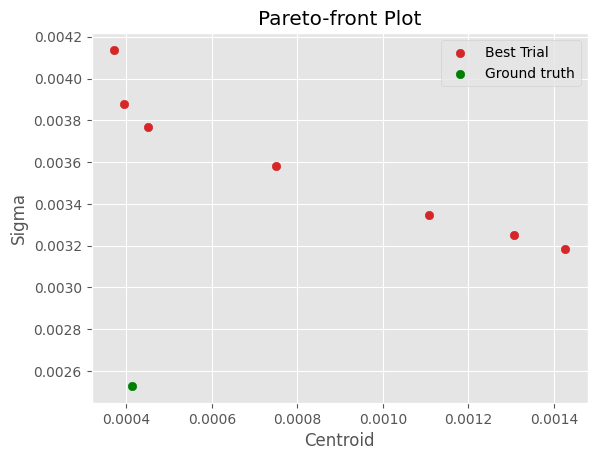

In [42]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
plt.ylabel('Sigma')
plt.xlabel('Centroid')
plt.scatter(centroid_ground, sigma_ground, color='green', label='Ground truth')
plt.legend(loc='best')

In [43]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum())

-13.283649893758692
-13.386671212502538
-12.506259676592173
-12.301794179118648
-12.368835013688702
-12.828519486384291
-13.388163599861594


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_9684/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_9684/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_9684/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_9684/Downstream_HKB_bender_profile.dat written to disk.
[0.0005032166403173247, 0.0033348498406202435] 0.46210379310353034


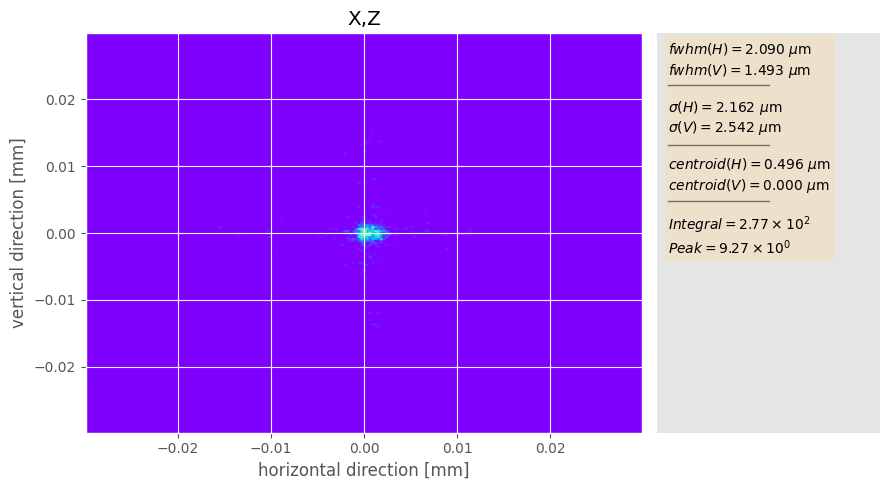

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_9684/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_9684/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_9684/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_9684/Downstream_HKB_bender_profile.dat written to disk.
[0.00088543513510587, 0.0032786008812913823] 0.5034168810278813


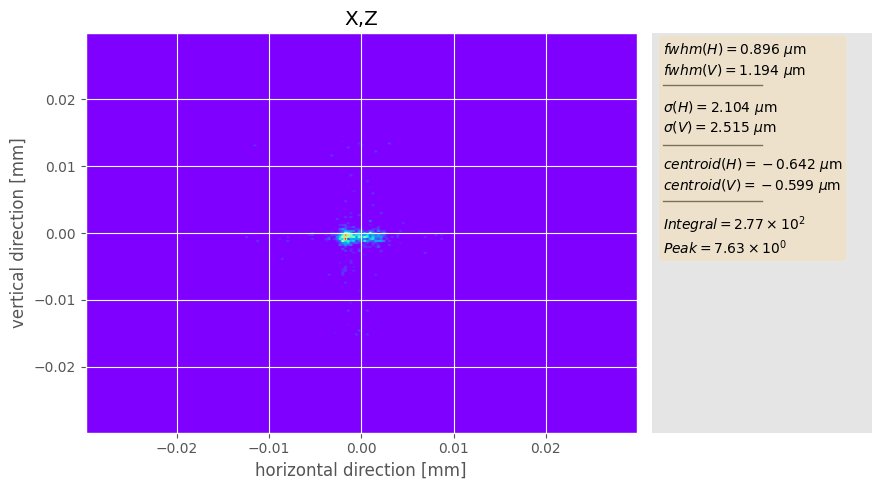

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_9684/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_9684/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_9684/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_9684/Downstream_HKB_bender_profile.dat written to disk.
[0.010630315963050542, 0.003059270661420493] 3.705829137256818


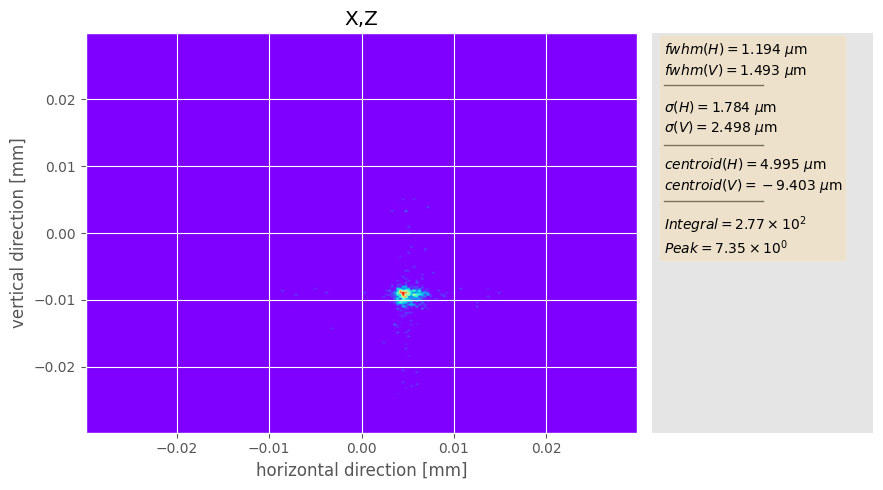

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_9684/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_9684/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_9684/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_9684/Downstream_HKB_bender_profile.dat written to disk.
[0.006454561890302154, 0.003110057585249784] 1.0439842737358527


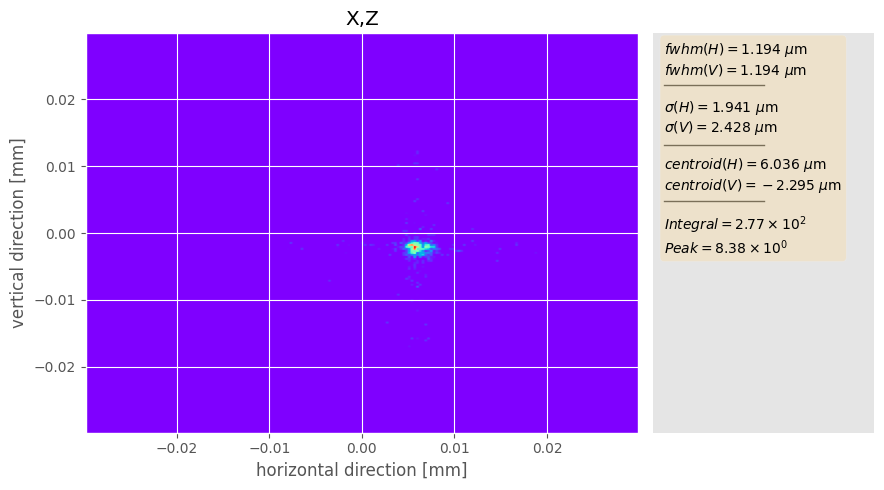

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_9684/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_9684/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_9684/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_9684/Downstream_HKB_bender_profile.dat written to disk.
[0.0023685004923036006, 0.0031305551987271863] 0.4789051515236666


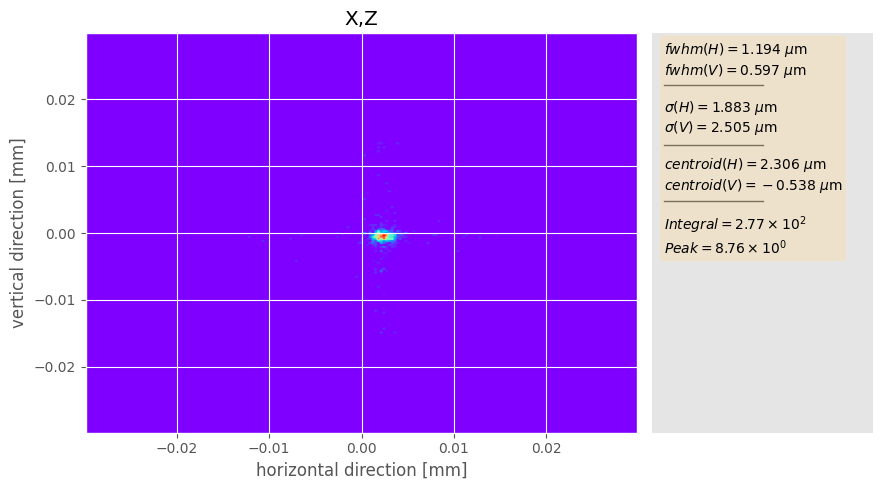

In [106]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values, t.user_attrs['wsum'])
    plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)

In [47]:
tnums = []
centroids = []
sigmas = []
wsums = []
for t in opt_trial.study.trials:
    if t.state in [optuna.trial.TrialState.PRUNED, optuna.trial.TrialState.FAIL]:
        continue
    tnums.append(t.number)
    centroids.append(t.values[0])
    sigmas.append(t.values[1])
    wsums.append(t.user_attrs['wsum'])
    
tnums = np.array(tnums)
centroids = np.array(centroids)
sigmas = np.array(sigmas)
wsums = np.array(wsums)

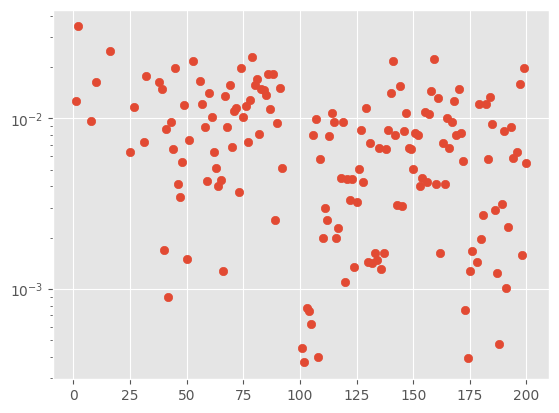

In [48]:
plt.scatter(tnums, centroids)
plt.yscale('log')

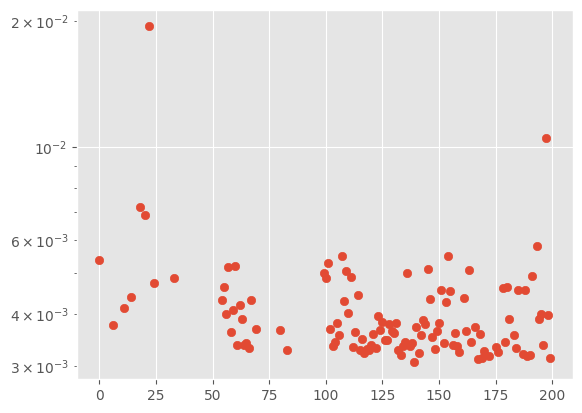

In [96]:
plt.scatter(tnums, sigmas)
plt.yscale('log')

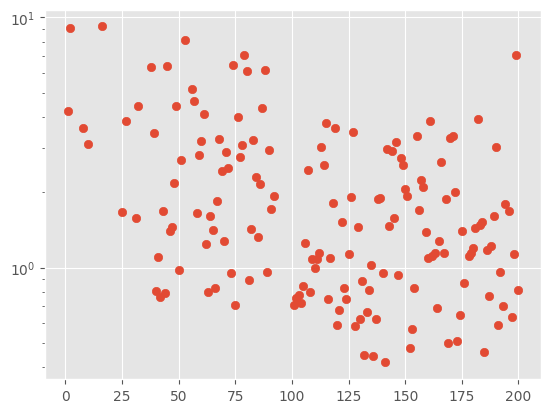

In [49]:
plt.scatter(tnums, wsums)
plt.yscale('log')

### Starting same procedure for different random structure 

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


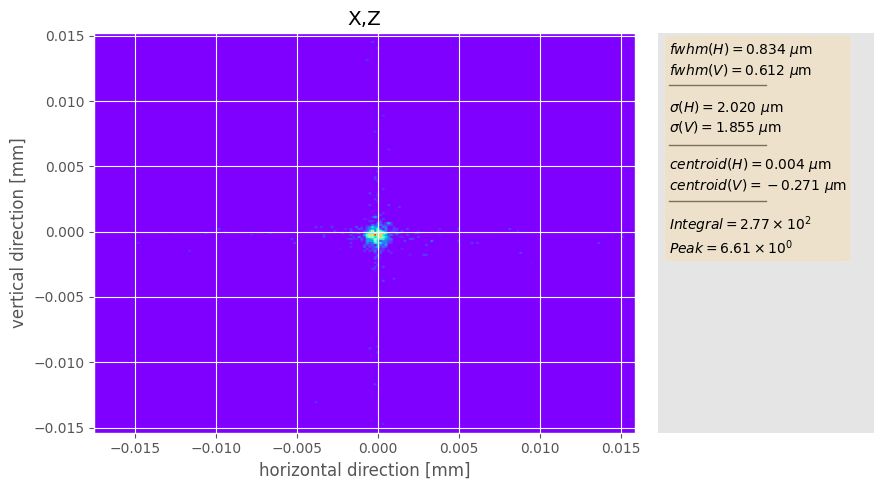

In [105]:
focusing_system = opt_common.reinitialize(input_beam_path=input_beam_path, bender=True)
beam, hist, dw = opt_common.get_beam_hist_dw(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
plot_shadow_beam_spatial_distribution(beam)

In [106]:
centroid_ground, *_ = opt_common.get_centroid_distance(photon_beam=beam)
sigma_ground, *_ = opt_common.get_sigma(photon_beam=beam, random_seed=DEFAULT_RANDOM_SEED)
centroid_ground, sigma_ground

(0.0002743679164684214, 0.0027418680323870043)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.
Random initialization is ['hkb_1', 'vkb_1', 'hkb_2', 'vkb_2', 'hkb_3', 'vkb_3', 'hkb_4', 'vkb_4'] [16.16790236325798, 36.78749105299613, -25.983811087521993, -43.26970399957091, 0.03260968496996106, -0.022099401560925706, -24.81688703301112, -3.850480877123843]


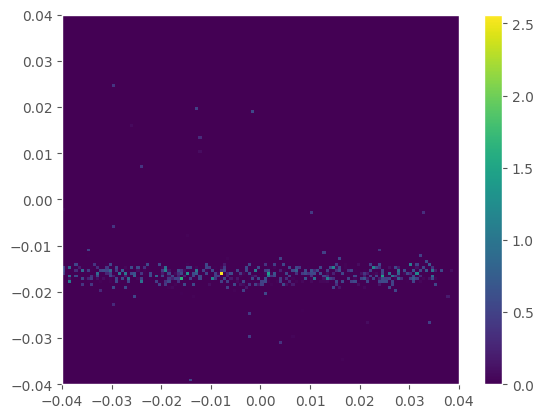

In [107]:
initial_movement, focusing_system, beam, hist, dw = opt_common.get_random_init(focusing_system, motor_types=list(move_motors_ranges.keys()),
                                                                               init_range=list(move_motors_ranges.values()),
                                                                               xrange=[-0.04, 0.04],yrange=[-0.04,0.04], 
                                                                               integral_threshold=100, random_seed=DEFAULT_RANDOM_SEED,
                                                                               nbins=128)
plt.pcolormesh(hist.vv, hist.hh, hist.data_2D.T)
plt.colorbar()
plt.show()

In [108]:
hist.data_2D.sum()

165.286295374562

In [139]:
focusing_system = movers.move_motors(focusing_system, list(move_motors_ranges.keys()), initial_absolute_positions + initial_movement, movement='absolute')

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


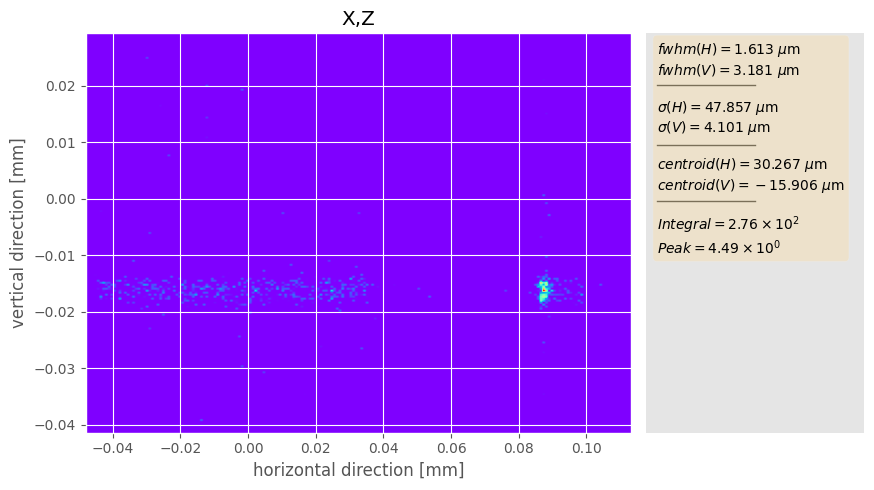

In [140]:
beam = opt_common.get_beam(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
plot_shadow_beam_spatial_distribution(beam)

#### Trying out joint optimization with 200 epochs first.

In [111]:

opt_trial = OptunaOptimizer(focusing_system, 
                            motor_types=list(move_motors_ranges.keys()), 
                            random_seed=DEFAULT_RANDOM_SEED, 
                            loss_parameters=['centroid', 'sigma'],
                            loss_min_value=5e-4,
                            use_gaussian_fit=False,
                            multi_objective_optimization=True,
                            camera_xrange=[-0.03, 0.03],
                            camera_yrange=[-0.03, 0.03],
                            camera_nbins=512)
#opt_trial.motor_ranges = centroid_ranges

In [119]:
opt_trial.reset()

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


In [120]:
base_sampler = optuna.integration.BoTorchSampler()

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_28594/3702032374.py:1: ExperimentalWarning: BoTorchSampler is experimental (supported from v2.4.0). The interface can change in the future.
  base_sampler = optuna.integration.BoTorchSampler()


In [121]:
opt_trial.set_optimizer_options(motor_ranges=list(move_motors_ranges.values()), integral_threshold=100, base_sampler=base_sampler, raise_prune_exception=True)

[I 2022-09-24 23:07:27,250] A new study created in memory with name: no-name-c0d6dfd4-2ec2-4615-8b72-5db0e0d6f530


In [ ]:
opt_trial.trials(200)

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_28594/1036378160.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


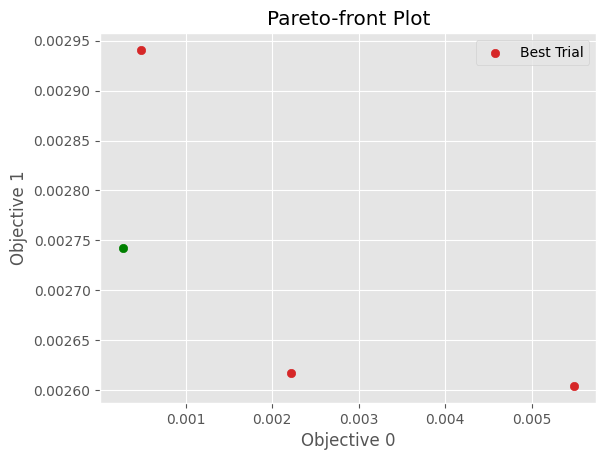

In [135]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
plt.scatter(centroid_ground, sigma_ground, color='green')

In [136]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum())

-11.156154330856026
-13.456432286196033
-12.05475814855554


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.
[0.005486368619161271, 0.002604106557345038]


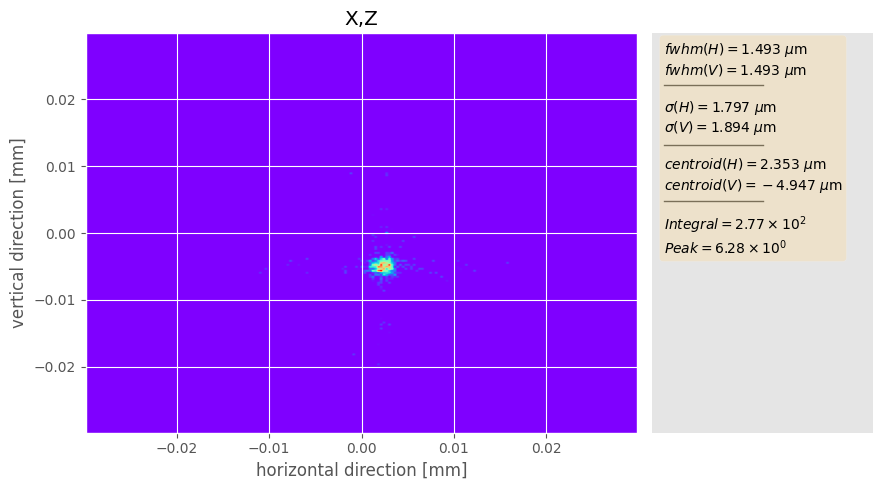

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.
[0.0004869526040894996, 0.0029407561865906194]


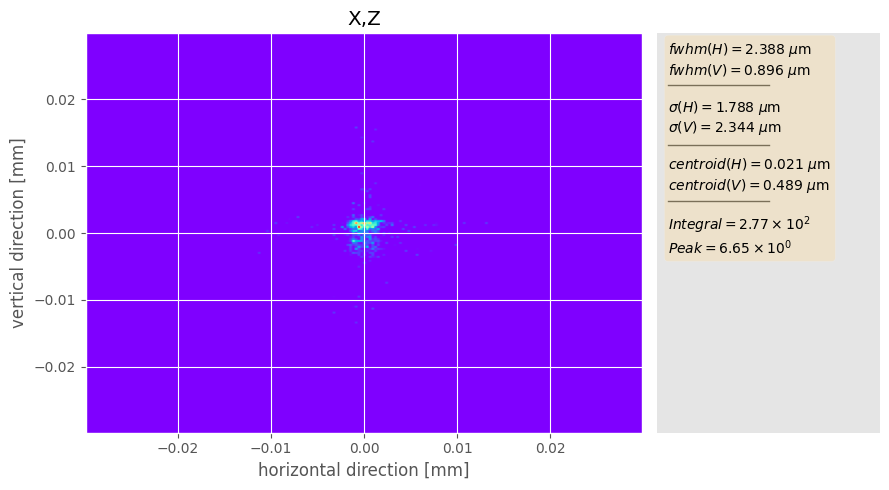

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.
[0.0022224953122590855, 0.0026172439332410743]


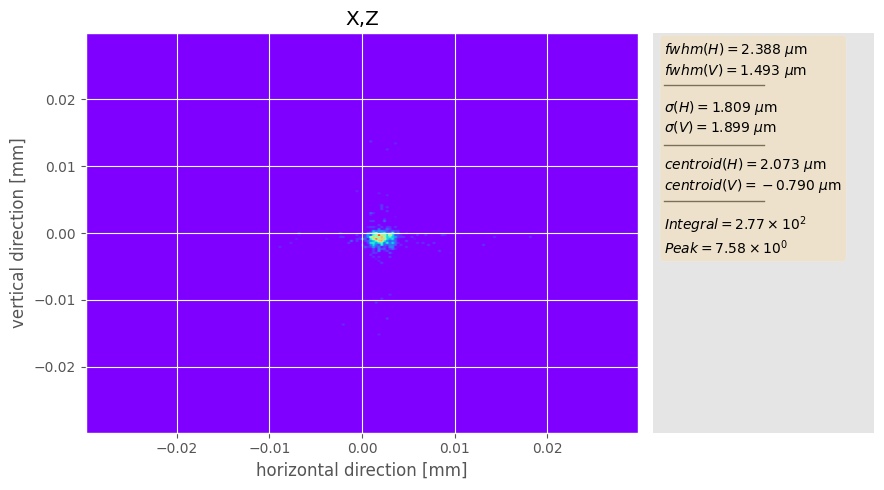

In [137]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values)
    plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)

#### Now trying out 100/100, first optimizing only the 3/4 motors.

In [141]:

opt_trial = OptunaOptimizer(focusing_system, 
                            motor_types=list(move_motors_ranges.keys()), 
                            random_seed=DEFAULT_RANDOM_SEED, 
                            loss_parameters=['centroid', 'sigma'],
                            loss_min_value=5e-4,
                            use_gaussian_fit=False,
                            multi_objective_optimization=True,
                            camera_xrange=[-0.03, 0.03],
                            camera_yrange=[-0.03, 0.03],
                            camera_nbins=512)
#opt_trial.motor_ranges = centroid_ranges

In [142]:
opt_trial.reset()

In [143]:
base_sampler = optuna.integration.BoTorchSampler()

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_28594/3702032374.py:1: ExperimentalWarning: BoTorchSampler is experimental (supported from v2.4.0). The interface can change in the future.
  base_sampler = optuna.integration.BoTorchSampler()


In [144]:
opt_trial.set_optimizer_options(motor_ranges=list(move_motors_ranges.values()), integral_threshold=100, base_sampler=base_sampler, raise_prune_exception=True)

[I 2022-09-24 23:45:57,116] A new study created in memory with name: no-name-c71d277d-735b-43b5-bc5a-e09f0135f2f3


In [145]:
opt_trial.trials(100, trial_motor_types=['hkb_4', 'vkb_4', 'hkb_3', 'vkb_3'])

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_28594/3699402942.py:85: ExperimentalWarning: PartialFixedSampler is experimental (supported from v2.4.0). The interface can change in the future.
  partial_sampler = optuna.samplers.PartialFixedSampler(fixed_params, self._base_sampler)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-0.04, 0.038539816339744834].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_28594/1036378160.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


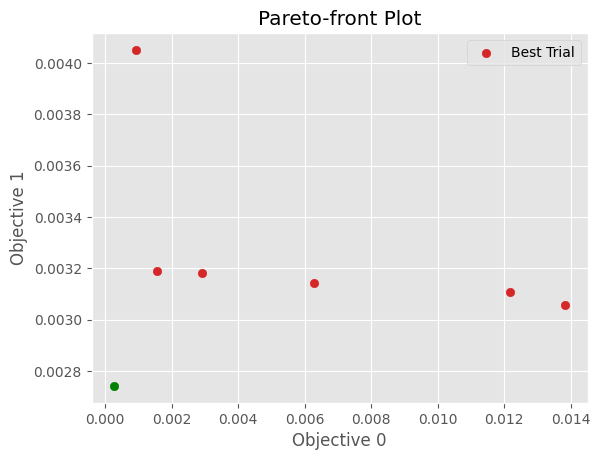

In [146]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
plt.scatter(centroid_ground, sigma_ground, color='green')

In [147]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum())

-12.500921200555123
-11.59046146310224
-12.202951722343718
-10.831114209145172
-10.1817035927129
-10.071191311891333


[0.0009192106096857698, 0.004050455595952688]


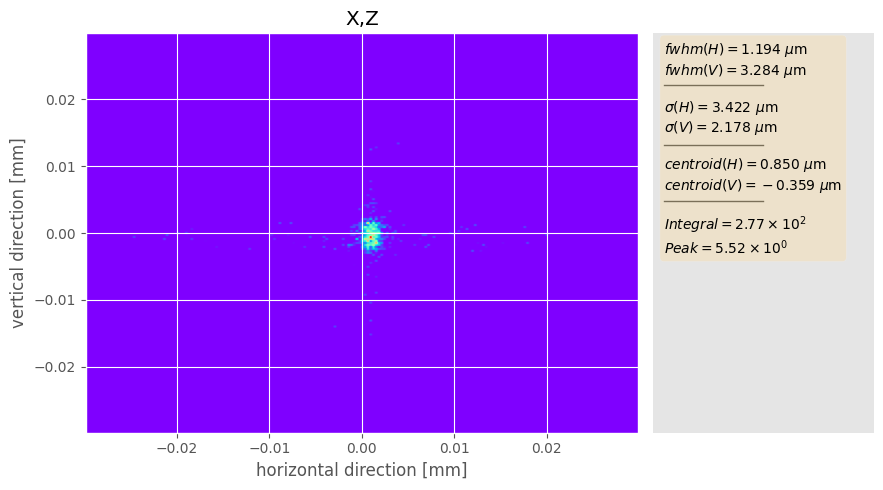

[0.002907722258893795, 0.0031825381826671006]


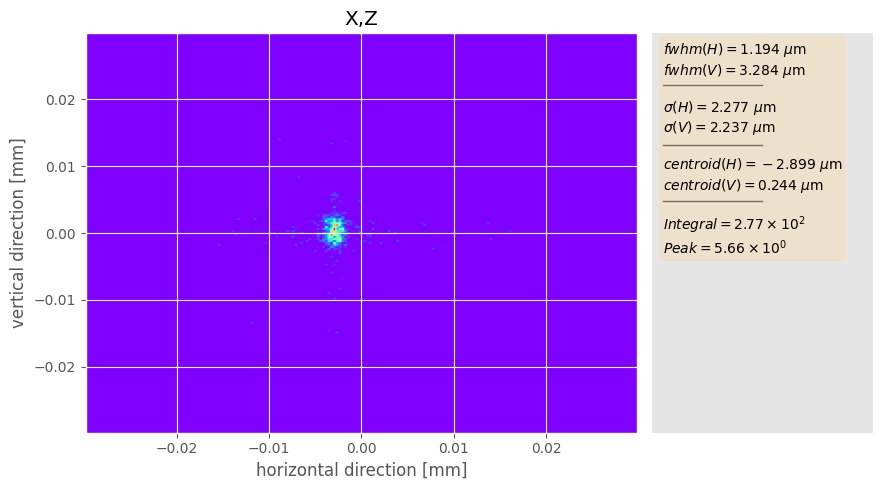

[0.001572547504039353, 0.0031894928317296126]


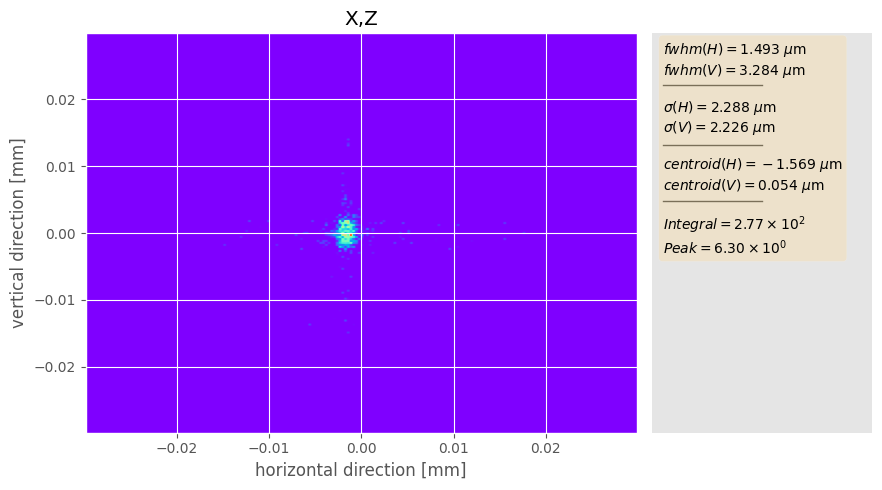

[0.006291015951024853, 0.003143301789281197]


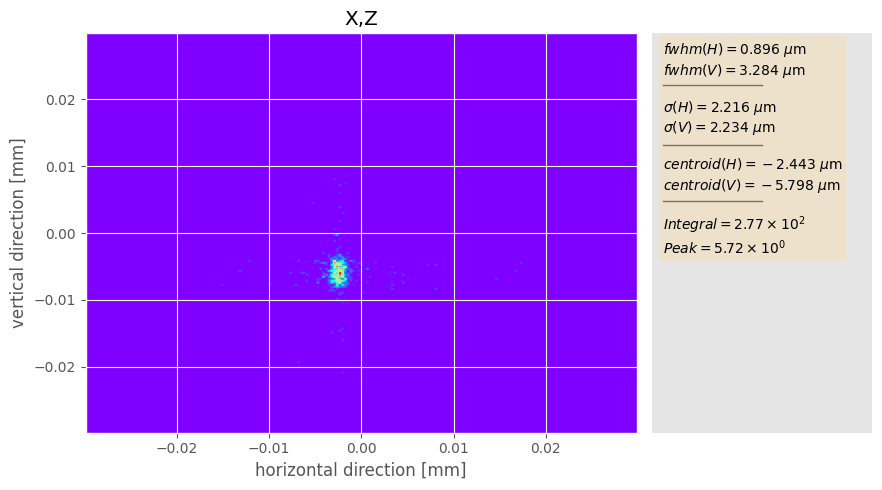

[0.012182620377186364, 0.0031074317724965965]


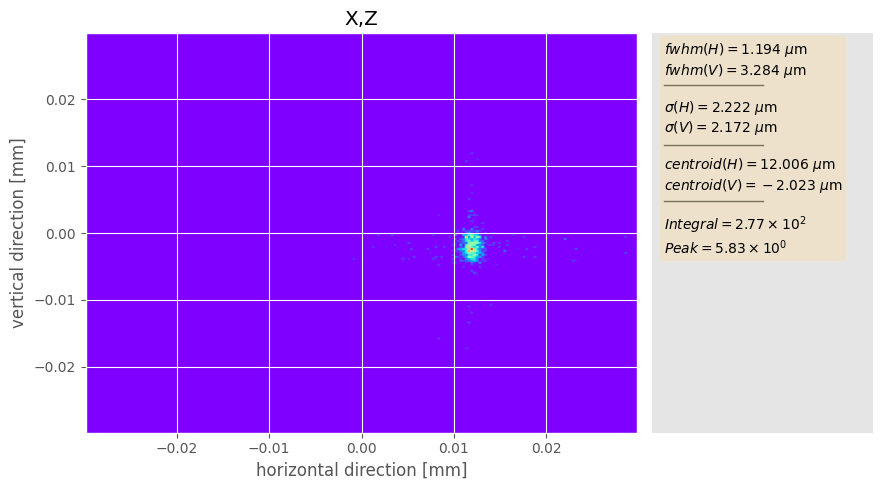

[0.013822380404893767, 0.0030588229927730366]


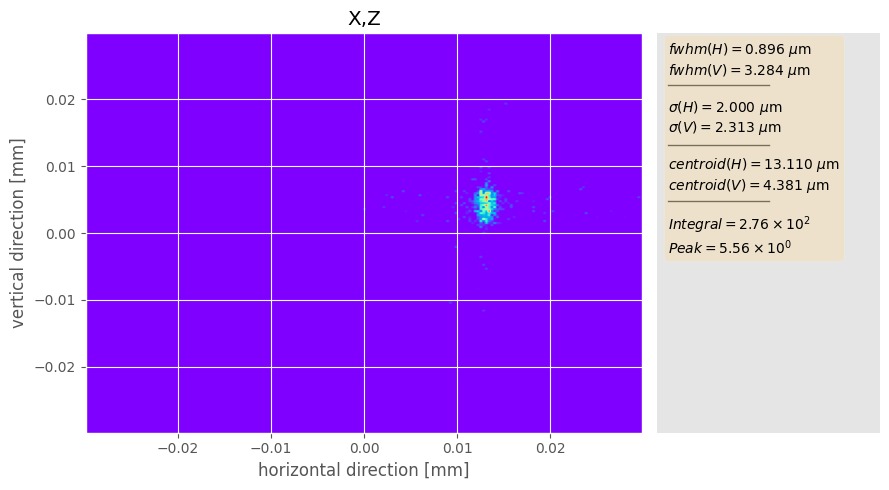

In [148]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values)
    plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)

In [149]:
opt_trial.trials(100)

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-0.04, 0.038539816339744834].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:50:55,649] Trial 100 finished with values: [0.0009936544532963233, 0.0031679462990487684] and parameters: {'hkb_1': 4.726999999999997, 'vkb_1': -5.765600000000006, 'hkb_2': -3.2923000000000044, 'vkb_2': -12.805800000000005, 'hkb_3': -0.03476401224401701, 'vkb_3': 0.026322511575784517, 'hkb_4': 25.6, 'vkb_4': 5.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Appli

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:50:58,507] Trial 101 finished with values: [0.012932675925069387, 0.0038777203582828694] and parameters: {'hkb_1': -10.366900000000001, 'vkb_1': -22.172700000000003, 'hkb_2': -3.300600000000003, 'vkb_2': -12.174400000000006, 'hkb_3': -0.03825467074800567, 'vkb_3': -0.0016027564561247529, 'hkb_4': 28.200000000000003, 'vkb_4': 4.200000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.999999999

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:51:01,563] Trial 102 finished with values: [0.0076837889014349115, 0.0032134237088208622] and parameters: {'hkb_1': 19.7466, 'vkb_1': -36.5732, 'hkb_2': 2.3817999999999984, 'vkb_2': 6.401999999999994, 'hkb_3': -0.017310719724073716, 'vkb_3': 0.015850536063818546, 'hkb_4': 25.5, 'vkb_4': 1.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/C

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:51:04,760] Trial 103 finished with values: [0.0015491575291679883, 0.00305411731298476] and parameters: {'hkb_1': 11.992299999999993, 'vkb_1': -18.3622, 'hkb_2': -0.01920000000000499, 'vkb_2': -0.22110000000000696, 'hkb_3': -0.04, 'vkb_3': 0.0245771823237902, 'hkb_4': 24.400000000000006, 'vkb_4': 5.899999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/App

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:51:07,592] Trial 104 finished with values: [0.004446629541380141, 0.003473421397962693] and parameters: {'hkb_1': 18.072999999999993, 'vkb_1': 18.27499999999999, 'hkb_2': 9.422199999999997, 'vkb_2': -42.0833, 'hkb_3': -0.024292036732051034, 'vkb_3': 0.02806784082777885, 'hkb_4': 29.400000000000006, 'vkb_4': 0.20000000000000284}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnin

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:51:10,552] Trial 105 finished with values: [0.0005995903923481749, 0.0031133826197188305] and parameters: {'hkb_1': 16.2072, 'vkb_1': -2.2794000000000025, 'hkb_2': 11.498299999999993, 'vkb_2': -14.615200000000002, 'hkb_3': -0.03476401224401701, 'vkb_3': 0.026322511575784517, 'hkb_4': 25.5, 'vkb_4': 4.800000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/A

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:51:13,427] Trial 106 finished with values: [0.0003890977089099867, 0.003429467271174207] and parameters: {'hkb_1': 34.7024, 'vkb_1': -22.0253, 'hkb_2': 33.09439999999999, 'vkb_2': -48.9196, 'hkb_3': -0.026037365984045366, 'vkb_3': 0.026322511575784517, 'hkb_4': 27.900000000000006, 'vkb_4': 4.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.ap

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:51:16,475] Trial 107 finished with values: [0.0003873074716109549, 0.0033766837613488903] and parameters: {'hkb_1': 19.351699999999994, 'vkb_1': -20.2266, 'hkb_2': 16.799499999999995, 'vkb_2': -28.4185, 'hkb_3': -0.019056048976068045, 'vkb_3': 0.02806784082777885, 'hkb_4': 29.0, 'vkb_4': 3.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:51:19,672] Trial 108 finished with values: [0.0010029029354671262, 0.0033280713658817157] and parameters: {'hkb_1': 35.350599999999986, 'vkb_1': -17.584600000000002, 'hkb_2': 9.298499999999997, 'vkb_2': -35.6584, 'hkb_3': -0.03476401224401701, 'vkb_3': 0.0245771823237902, 'hkb_4': 26.800000000000004, 'vkb_4': 4.899999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnin

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:51:22,210] Trial 109 finished with values: [0.0003402460739362589, 0.0033923839367220312] and parameters: {'hkb_1': -8.794900000000005, 'vkb_1': -28.5133, 'hkb_2': 36.72229999999999, 'vkb_2': -46.3994, 'hkb_3': -0.017310719724073716, 'vkb_3': 0.0245771823237902, 'hkb_4': 28.700000000000003, 'vkb_4': 4.399999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:51:25,186] Trial 110 finished with values: [0.002810008968419221, 0.003419448914955743] and parameters: {'hkb_1': 31.579499999999996, 'vkb_1': 3.7945999999999955, 'hkb_2': -21.976100000000002, 'vkb_2': 42.127999999999986, 'hkb_3': -0.026037365984045366, 'vkb_3': 0.021086523819801535, 'hkb_4': 28.800000000000004, 'vkb_4': 3.200000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999999999999

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:51:27,998] Trial 111 finished with values: [0.0058584256483606234, 0.003741551331897891] and parameters: {'hkb_1': -1.4764000000000053, 'vkb_1': -23.170500000000004, 'hkb_2': 31.00609999999999, 'vkb_2': -22.097300000000004, 'hkb_3': -0.03301868299202268, 'vkb_3': 0.0071238898038469, 'hkb_4': 24.5, 'vkb_4': 6.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applica

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:51:31,389] Trial 112 finished with values: [0.005175132528498438, 0.003720818027160074] and parameters: {'hkb_1': 19.4593, 'vkb_1': -34.069900000000004, 'hkb_2': -0.33610000000000184, 'vkb_2': -44.9662, 'hkb_3': 0.003633231299858236, 'vkb_3': 0.022831853071795867, 'hkb_4': 30.0, 'vkb_4': 5.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:51:34,616] Trial 113 finished with values: [0.006221232077023603, 0.0032465149521453437] and parameters: {'hkb_1': 31.1982, 'vkb_1': 11.605399999999996, 'hkb_2': 44.236699999999985, 'vkb_2': -40.3275, 'hkb_3': -0.026037365984045366, 'vkb_3': 0.02981317007977318, 'hkb_4': 21.800000000000004, 'vkb_4': 7.200000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:51:37,528] Trial 114 finished with values: [0.0018715787414554158, 0.0032544016388902984] and parameters: {'hkb_1': 6.284099999999995, 'vkb_1': -22.9552, 'hkb_2': 30.667599999999993, 'vkb_2': -48.3865, 'hkb_3': -0.03476401224401701, 'vkb_3': 0.02806784082777885, 'hkb_4': 25.900000000000006, 'vkb_4': 4.800000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:51:40,045] Trial 115 finished with values: [0.003750065301151228, 0.003150879078738727] and parameters: {'hkb_1': -6.089900000000007, 'vkb_1': -27.2432, 'hkb_2': -16.342800000000004, 'vkb_2': 17.742999999999995, 'hkb_3': -0.036509341496011344, 'vkb_3': 0.0245771823237902, 'hkb_4': 28.300000000000004, 'vkb_4': 3.8000000000000043}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warni

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:51:43,825] Trial 116 finished with values: [0.007975631726670847, 0.0029433399076585175] and parameters: {'hkb_1': 49.92349999999999, 'vkb_1': -31.0438, 'hkb_2': 45.64649999999999, 'vkb_2': 1.3580999999999932, 'hkb_3': -0.026037365984045366, 'vkb_3': 0.02806784082777885, 'hkb_4': 18.700000000000003, 'vkb_4': 3.8000000000000043}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnin

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:51:46,579] Trial 117 finished with values: [0.0008818780069398018, 0.0027253386814622433] and parameters: {'hkb_1': 3.3189999999999955, 'vkb_1': -28.9691, 'hkb_2': 27.526599999999988, 'vkb_2': 45.936899999999994, 'hkb_3': -0.027782695236039694, 'vkb_3': 0.026322511575784517, 'hkb_4': 27.200000000000003, 'vkb_4': 3.200000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  war

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:51:50,092] Trial 118 finished with values: [0.0014309157578129806, 0.0031434085489729945] and parameters: {'hkb_1': 16.959599999999995, 'vkb_1': 19.761799999999994, 'hkb_2': 40.08659999999999, 'vkb_2': 15.995999999999995, 'hkb_3': -0.04, 'vkb_3': 0.0245771823237902, 'hkb_4': 23.700000000000003, 'vkb_4': 3.8999999999999986}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.wa

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:51:53,407] Trial 119 finished with values: [0.007781796005265358, 0.003120600630775381] and parameters: {'hkb_1': -21.018900000000002, 'vkb_1': -5.886700000000005, 'hkb_2': 35.23719999999999, 'vkb_2': 26.242999999999995, 'hkb_3': -0.006838744212107742, 'vkb_3': 0.033303828583761845, 'hkb_4': 25.0, 'vkb_4': 5.399999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:51:57,323] Trial 120 finished with values: [0.004513493348590408, 0.00414039847430951] and parameters: {'hkb_1': 46.69739999999999, 'vkb_1': 41.7033, 'hkb_2': 9.119099999999996, 'vkb_2': 47.10249999999999, 'hkb_3': -0.010329402716096399, 'vkb_3': 0.02981317007977318, 'hkb_4': 28.900000000000006, 'vkb_4': 0.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applicati

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:52:02,007] Trial 121 finished with values: [0.011994344370971967, 0.0030645921894067348] and parameters: {'hkb_1': 7.400299999999994, 'vkb_1': -28.172800000000002, 'hkb_2': -24.453000000000003, 'vkb_2': 38.0466, 'hkb_3': 0.03155849933176751, 'vkb_3': 0.019341194567807203, 'hkb_4': 29.700000000000003, 'vkb_4': 6.700000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnin

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:52:05,594] Trial 122 finished with values: [0.009234647664556414, 0.0033974518759032598] and parameters: {'hkb_1': 15.9165, 'vkb_1': 20.451999999999998, 'hkb_2': 39.94229999999999, 'vkb_2': -38.8508, 'hkb_3': 0.010614548307835557, 'vkb_3': 0.021086523819801535, 'hkb_4': 27.200000000000003, 'vkb_4': 5.600000000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/A

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:52:08,876] Trial 123 finished with values: [0.0028464325203280748, 0.003419379157311708] and parameters: {'hkb_1': 33.1232, 'vkb_1': -32.7699, 'hkb_2': 49.206199999999995, 'vkb_2': -31.5944, 'hkb_3': -0.036509341496011344, 'vkb_3': 0.033303828583761845, 'hkb_4': 21.400000000000006, 'vkb_4': 1.6000000000000014}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applicat

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:52:12,963] Trial 124 finished with values: [0.011568386840375337, 0.003019109435553102] and parameters: {'hkb_1': 49.25489999999999, 'vkb_1': -17.147600000000004, 'hkb_2': 46.66159999999999, 'vkb_2': 16.543999999999997, 'hkb_3': -0.015565390472079388, 'vkb_3': 0.036794487087750495, 'hkb_4': 18.400000000000006, 'vkb_4': 3.3000000000000043}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:52:17,719] Trial 125 finished with values: [0.00860839335318068, 0.0028761186643768526] and parameters: {'hkb_1': 46.24969999999999, 'vkb_1': -43.9483, 'hkb_2': 25.3857, 'vkb_2': 42.358999999999995, 'hkb_3': -0.04, 'vkb_3': 0.022831853071795867, 'hkb_4': 19.800000000000004, 'vkb_4': 11.600000000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oas

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:52:22,569] Trial 126 finished with values: [0.014517334980822123, 0.003476704194485455] and parameters: {'hkb_1': 37.95439999999999, 'vkb_1': 11.713099999999997, 'hkb_2': 41.40929999999999, 'vkb_2': 40.44409999999999, 'hkb_3': 0.033303828583761845, 'vkb_3': 0.019341194567807203, 'hkb_4': 28.1, 'vkb_4': 5.700000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:52:26,974] Trial 127 finished with values: [0.00825223820197349, 0.0034108440881908597] and parameters: {'hkb_1': -32.1655, 'vkb_1': -33.7892, 'hkb_2': 48.9785, 'vkb_2': -17.753300000000003, 'hkb_3': 0.014105206811824214, 'vkb_3': 0.036794487087750495, 'hkb_4': 29.0, 'vkb_4': 3.3999999999999986}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.a

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:52:31,736] Trial 128 finished with values: [0.013466270289887432, 0.0033902340761403573] and parameters: {'hkb_1': -7.068800000000003, 'vkb_1': -45.4743, 'hkb_2': 23.50349999999999, 'vkb_2': -32.324600000000004, 'hkb_3': 0.03155849933176751, 'vkb_3': 0.02806784082777885, 'hkb_4': 29.6, 'vkb_4': 9.400000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Appli

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:52:35,696] Trial 129 finished with values: [0.007566443216949113, 0.003056134218199221] and parameters: {'hkb_1': 19.2491, 'vkb_1': -41.3003, 'hkb_2': 14.730899999999991, 'vkb_2': 31.125499999999988, 'hkb_3': 0.0071238898038469, 'vkb_3': 0.0245771823237902, 'hkb_4': 28.200000000000003, 'vkb_4': 4.399999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Appli

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:52:38,535] Trial 130 finished with values: [0.006958258105401201, 0.0028695710258445674] and parameters: {'hkb_1': 5.832199999999993, 'vkb_1': -20.393500000000003, 'hkb_2': 34.36009999999999, 'vkb_2': -17.095200000000006, 'hkb_3': -0.03301868299202268, 'vkb_3': 0.02806784082777885, 'hkb_4': 19.5, 'vkb_4': 7.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applicat

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:52:42,453] Trial 131 finished with values: [0.01375760211112602, 0.0034558573440588354] and parameters: {'hkb_1': 7.694799999999994, 'vkb_1': -25.301900000000003, 'hkb_2': 45.77959999999999, 'vkb_2': -30.4421, 'hkb_3': 0.012359877559829889, 'vkb_3': 0.03504915783575618, 'hkb_4': 24.6, 'vkb_4': 7.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:52:45,462] Trial 132 finished with values: [0.00825648159148602, 0.0029460701151973875] and parameters: {'hkb_1': 34.1814, 'vkb_1': -2.129100000000001, 'hkb_2': 40.01769999999999, 'vkb_2': 15.7436, 'hkb_3': -0.027782695236039694, 'vkb_3': 0.026322511575784517, 'hkb_4': 19.300000000000004, 'vkb_4': 8.600000000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Ap

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:52:50,195] Trial 133 finished with values: [0.011597803249000439, 0.0037062740857611836] and parameters: {'hkb_1': -32.0411, 'vkb_1': 12.908699999999996, 'hkb_2': 20.071099999999987, 'vkb_2': 9.005399999999995, 'hkb_3': 0.02981317007977318, 'vkb_3': 0.015850536063818546, 'hkb_4': 28.5, 'vkb_4': 10.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:52:53,600] Trial 134 finished with values: [0.0008674661816080307, 0.003042551906575605] and parameters: {'hkb_1': 35.2157, 'vkb_1': -22.815700000000003, 'hkb_2': 45.676799999999986, 'vkb_2': 15.165299999999988, 'hkb_3': -0.029528024488034023, 'vkb_3': 0.02806784082777885, 'hkb_4': 27.300000000000004, 'vkb_4': 3.200000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warni

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:52:57,581] Trial 135 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:53:01,969] Trial 136 finished with values: [0.024827602318067382, 0.004227570410977371] and parameters: {'hkb_1': 10.650599999999997, 'vkb_1': 47.6142, 'hkb_2': 6.7708999999999975, 'vkb_2': 1.7856999999999985, 'hkb_3': -0.013820061220085056, 'vkb_3': -0.036509341496011344, 'hkb_4': 25.900000000000006, 'vkb_4': 9.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/App

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:53:05,001] Trial 137 finished with values: [0.007333103190893294, 0.0033332864806796827] and parameters: {'hkb_1': 10.464799999999997, 'vkb_1': 26.464699999999993, 'hkb_2': 41.67779999999999, 'vkb_2': 27.772999999999996, 'hkb_3': -0.013820061220085056, 'vkb_3': 0.026322511575784517, 'hkb_4': 22.800000000000004, 'vkb_4': 1.2000000000000028}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999999999999

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:53:09,450] Trial 138 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:53:13,247] Trial 139 finished with values: [0.014137573701843873, 0.0029658050088837654] and parameters: {'hkb_1': 35.10749999999999, 'vkb_1': -37.7806, 'hkb_2': 14.84689999999999, 'vkb_2': 40.956199999999995, 'hkb_3': -0.006838744212107742, 'vkb_3': 0.03504915783575618, 'hkb_4': 18.700000000000003, 'vkb_4': 3.6000000000000014}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnin

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:53:17,952] Trial 140 finished with values: [0.015369747101398793, 0.0034275453502011053] and parameters: {'hkb_1': 32.9768, 'vkb_1': 16.452299999999994, 'hkb_2': -32.605199999999996, 'vkb_2': -28.780800000000003, 'hkb_3': 0.03504915783575618, 'vkb_3': 0.0245771823237902, 'hkb_4': 28.0, 'vkb_4': 7.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:53:21,222] Trial 141 finished with values: [0.006512616863763947, 0.002774676831140057] and parameters: {'hkb_1': -20.682000000000002, 'vkb_1': -37.863, 'hkb_2': 37.93889999999999, 'vkb_2': 48.80319999999999, 'hkb_3': -0.00509341496011341, 'vkb_3': 0.021086523819801535, 'hkb_4': 25.0, 'vkb_4': 5.899999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applic

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:53:24,111] Trial 142 finished with values: [0.006654183108303979, 0.0034799173995412767] and parameters: {'hkb_1': 2.9553999999999974, 'vkb_1': -28.038200000000003, 'hkb_2': -45.4677, 'vkb_2': 26.900999999999996, 'hkb_3': -0.04, 'vkb_3': 0.022831853071795867, 'hkb_4': 18.700000000000003, 'vkb_4': 7.399999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/App

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:53:27,048] Trial 143 finished with values: [0.009481859044388322, 0.003174642275299247] and parameters: {'hkb_1': -48.0138, 'vkb_1': -33.441, 'hkb_2': 11.924999999999997, 'vkb_2': 32.652699999999996, 'hkb_3': -0.013820061220085056, 'vkb_3': 0.022831853071795867, 'hkb_4': 20.400000000000006, 'vkb_4': 2.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/O

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:53:31,363] Trial 144 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:53:36,008] Trial 145 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:53:39,394] Trial 146 finished with values: [0.007623449162745457, 0.0026880754608915747] and parameters: {'hkb_1': 14.412700000000001, 'vkb_1': -36.0219, 'hkb_2': 39.356999999999985, 'vkb_2': 32.46369999999999, 'hkb_3': -0.03825467074800567, 'vkb_3': 0.0245771823237902, 'hkb_4': 27.300000000000004, 'vkb_4': 10.400000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warning

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:53:43,507] Trial 147 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:53:46,069] Trial 148 finished with values: [0.003855663124129979, 0.0026380672904185195] and parameters: {'hkb_1': 3.442299999999996, 'vkb_1': -30.335, 'hkb_2': 32.17169999999999, 'vkb_2': 49.9353, 'hkb_3': -0.03825467074800567, 'vkb_3': 0.026322511575784517, 'hkb_4': 27.5, 'vkb_4': 1.2000000000000028}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oas

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:53:49,766] Trial 149 finished with values: [0.002381745293586017, 0.003982211706044228] and parameters: {'hkb_1': 32.67229999999999, 'vkb_1': -48.4861, 'hkb_2': -12.697200000000002, 'vkb_2': -34.6083, 'hkb_3': -0.026037365984045366, 'vkb_3': 0.036794487087750495, 'hkb_4': 26.0, 'vkb_4': 0.3000000000000007}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:53:53,033] Trial 150 finished with values: [0.0074763365287272045, 0.002711607512375543] and parameters: {'hkb_1': 13.649199999999993, 'vkb_1': -27.3672, 'hkb_2': 15.321699999999993, 'vkb_2': 45.26759999999999, 'hkb_3': -0.031273353740028355, 'vkb_3': 0.02806784082777885, 'hkb_4': 18.400000000000006, 'vkb_4': 0.40000000000000213}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warn

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:53:56,051] Trial 151 finished with values: [0.00323827628455978, 0.002609367362614611] and parameters: {'hkb_1': -3.2702000000000027, 'vkb_1': -50.0, 'hkb_2': 49.99999999999999, 'vkb_2': 49.99999999999999, 'hkb_3': -0.036509341496011344, 'vkb_3': 0.0245771823237902, 'hkb_4': 22.1, 'vkb_4': 5.800000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applicatio

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:54:00,763] Trial 152 finished with values: [0.017490743104944733, 0.0035010747138516417] and parameters: {'hkb_1': 27.9452, 'vkb_1': -36.8279, 'hkb_2': 45.12719999999999, 'vkb_2': 33.95779999999999, 'hkb_3': -0.04, 'vkb_3': -0.022546707480056705, 'hkb_4': 20.6, 'vkb_4': 7.800000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Cont

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:54:05,235] Trial 153 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:54:09,530] Trial 154 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:54:12,645] Trial 155 finished with values: [0.0026841005532779977, 0.003122959840990706] and parameters: {'hkb_1': -25.2178, 'vkb_1': -8.596600000000002, 'hkb_2': 43.43759999999999, 'vkb_2': 1.883899999999997, 'hkb_3': -0.026037365984045366, 'vkb_3': 0.036794487087750495, 'hkb_4': 27.400000000000006, 'vkb_4': 1.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Appl

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:54:17,878] Trial 156 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:54:22,183] Trial 157 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:54:26,282] Trial 158 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:54:29,304] Trial 159 finished with values: [0.005154264266611962, 0.002762499663056993] and parameters: {'hkb_1': -40.9113, 'vkb_1': -37.3316, 'hkb_2': 49.491699999999994, 'vkb_2': 36.272699999999986, 'hkb_3': -0.027782695236039694, 'vkb_3': 0.026322511575784517, 'hkb_4': 29.200000000000003, 'vkb_4': -0.5999999999999979}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:54:32,972] Trial 160 finished with values: [0.010233444948933981, 0.0032217204370527993] and parameters: {'hkb_1': 40.0055, 'vkb_1': -6.821000000000005, 'hkb_2': 11.475099999999998, 'vkb_2': -7.1958000000000055, 'hkb_3': -0.03476401224401701, 'vkb_3': 0.03504915783575618, 'hkb_4': 16.1, 'vkb_4': 4.899999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Appl

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:54:37,524] Trial 161 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-09-24 23:54:42,744] Trial 162 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: Th

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:54:46,954] Trial 163 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:54:50,680] Trial 164 finished with values: [0.007697686423829647, 0.002994389720413379] and parameters: {'hkb_1': 38.452499999999986, 'vkb_1': -37.6711, 'hkb_2': -18.087400000000002, 'vkb_2': 38.74719999999999, 'hkb_3': -0.03301868299202268, 'vkb_3': 0.02806784082777885, 'hkb_4': 22.400000000000006, 'vkb_4': 8.400000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warning

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:54:55,213] Trial 165 finished with values: [0.01039413403473088, 0.003324667288637367] and parameters: {'hkb_1': 49.12509999999999, 'vkb_1': -16.848400000000005, 'hkb_2': 49.4888, 'vkb_2': 44.78789999999999, 'hkb_3': 0.008869219055841225, 'vkb_3': 0.026322511575784517, 'hkb_4': 28.300000000000004, 'vkb_4': 9.200000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:54:59,317] Trial 166 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-09-24 23:55:03,978] Trial 167 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: Th

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:55:09,060] Trial 168 finished with values: [0.014866106122415462, 0.004139332600283581] and parameters: {'hkb_1': 47.221299999999985, 'vkb_1': -41.986000000000004, 'hkb_2': -45.5277, 'vkb_2': 16.562799999999996, 'hkb_3': -0.04, 'vkb_3': -0.019056048976068045, 'hkb_4': 28.800000000000004, 'vkb_4': 9.200000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/App

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:55:13,929] Trial 169 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:55:19,123] Trial 170 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:55:24,142] Trial 171 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:55:28,158] Trial 172 finished with values: [0.013025111043984901, 0.0027941703634543186] and parameters: {'hkb_1': -1.2731000000000066, 'vkb_1': -28.8778, 'hkb_2': 45.341599999999985, 'vkb_2': 33.20819999999999, 'hkb_3': 0.008869219055841225, 'vkb_3': 0.021086523819801535, 'hkb_4': 23.200000000000003, 'vkb_4': -0.3999999999999986}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  war

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:55:31,194] Trial 173 finished with values: [0.010655760025517262, 0.002775833830978453] and parameters: {'hkb_1': 3.3936999999999955, 'vkb_1': -17.913700000000006, 'hkb_2': 30.5569, 'vkb_2': 48.61399999999999, 'hkb_3': -0.029528024488034023, 'vkb_3': 0.02981317007977318, 'hkb_4': 17.1, 'vkb_4': 7.899999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Appli

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:55:35,770] Trial 174 finished with values: [0.010222250879307287, 0.002989181777242159] and parameters: {'hkb_1': -14.222900000000003, 'vkb_1': -44.1009, 'hkb_2': 15.029799999999994, 'vkb_2': 41.81009999999999, 'hkb_3': -0.0016027564561247529, 'vkb_3': 0.017595865315812878, 'hkb_4': 25.200000000000003, 'vkb_4': -0.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/A

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:55:40,263] Trial 175 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:55:43,890] Trial 176 finished with values: [0.007547285253427149, 0.0038281166121760064] and parameters: {'hkb_1': 0.9092999999999947, 'vkb_1': -33.0546, 'hkb_2': 10.672399999999996, 'vkb_2': 49.42609999999999, 'hkb_3': -0.03825467074800567, 'vkb_3': -0.003348085708119078, 'hkb_4': 29.5, 'vkb_4': 11.300000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Ap

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:55:48,264] Trial 177 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:55:52,797] Trial 178 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:55:58,260] Trial 179 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:56:01,842] Trial 180 finished with values: [0.007808822140360566, 0.0029097209464384937] and parameters: {'hkb_1': 23.221599999999995, 'vkb_1': -12.352500000000006, 'hkb_2': 41.650699999999986, 'vkb_2': 40.23599999999999, 'hkb_3': -0.012074731968090727, 'vkb_3': 0.019341194567807203, 'hkb_4': 24.800000000000004, 'vkb_4': 0.8000000000000007}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.999999999999

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:56:06,650] Trial 181 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:56:11,054] Trial 182 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:56:15,622] Trial 183 finished with values: [0.008806226133090575, 0.0031198664981823714] and parameters: {'hkb_1': -36.9078, 'vkb_1': -38.559, 'hkb_2': 19.866199999999992, 'vkb_2': 46.88709999999999, 'hkb_3': 0.021086523819801535, 'vkb_3': 0.02981317007977318, 'hkb_4': 29.5, 'vkb_4': 3.8999999999999986}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oa

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-09-24 23:56:21,189] Trial 184 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: Th

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:56:26,963] Trial 185 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:56:31,390] Trial 186 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:56:36,499] Trial 187 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-09-24 23:56:41,526] Trial 188 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: Th

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:56:45,471] Trial 189 finished with values: [0.007442302091695036, 0.0030103478611601107] and parameters: {'hkb_1': -15.467600000000004, 'vkb_1': -30.2833, 'hkb_2': 23.1036, 'vkb_2': 34.709199999999996, 'hkb_3': -0.04, 'vkb_3': 0.03155849933176751, 'hkb_4': 21.0, 'vkb_4': 7.600000000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Con

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:56:49,001] Trial 190 finished with values: [0.0062299121216287355, 0.002916294836764803] and parameters: {'hkb_1': 26.259899999999988, 'vkb_1': -11.5852, 'hkb_2': 10.409499999999994, 'vkb_2': 49.91659999999999, 'hkb_3': -0.03301868299202268, 'vkb_3': 0.022831853071795867, 'hkb_4': 24.1, 'vkb_4': 11.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasy

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:56:53,232] Trial 191 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:56:57,899] Trial 192 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:57:02,413] Trial 193 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:57:07,528] Trial 194 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:57:11,878] Trial 195 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:57:15,338] Trial 196 finished with values: [0.011512974851665431, 0.0033118340885304] and parameters: {'hkb_1': -23.072200000000002, 'vkb_1': -42.753, 'hkb_2': 38.79119999999999, 'vkb_2': -14.137700000000002, 'hkb_3': -0.012074731968090727, 'vkb_3': 0.03155849933176751, 'hkb_4': 20.0, 'vkb_4': 7.100000000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applic

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:57:20,191] Trial 197 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:57:26,003] Trial 198 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:57:30,623] Trial 199 pruned. 


/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_28594/1036378160.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


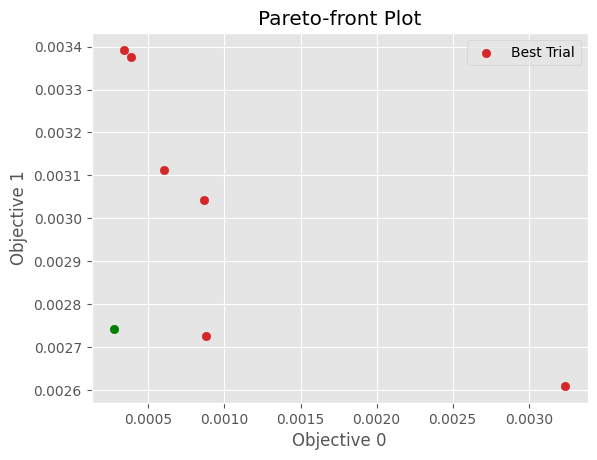

In [150]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
plt.scatter(centroid_ground, sigma_ground, color='green')

In [151]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum())

-13.191309300089534
-13.547152866907552
-13.672063833826936
-12.938619397465729
-12.844992703386975
-11.681361578515792


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.
[0.0005995903923481749, 0.0031133826197188305]


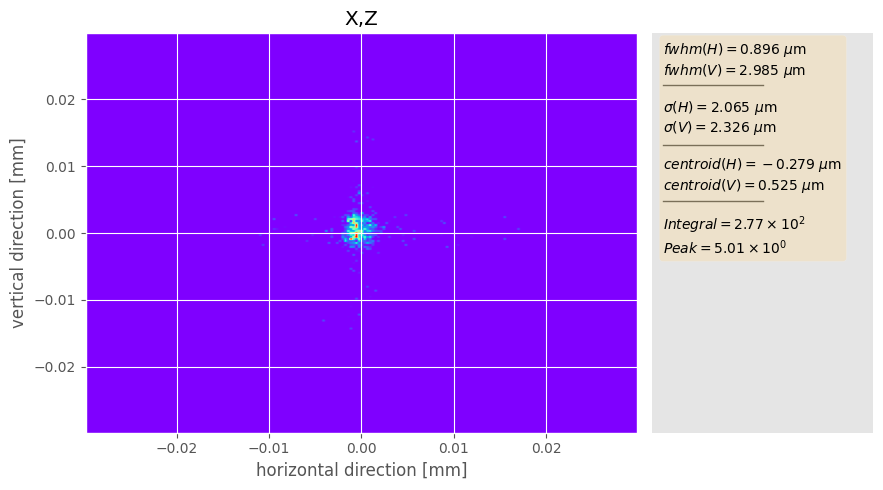

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.
[0.0003873074716109549, 0.0033766837613488903]


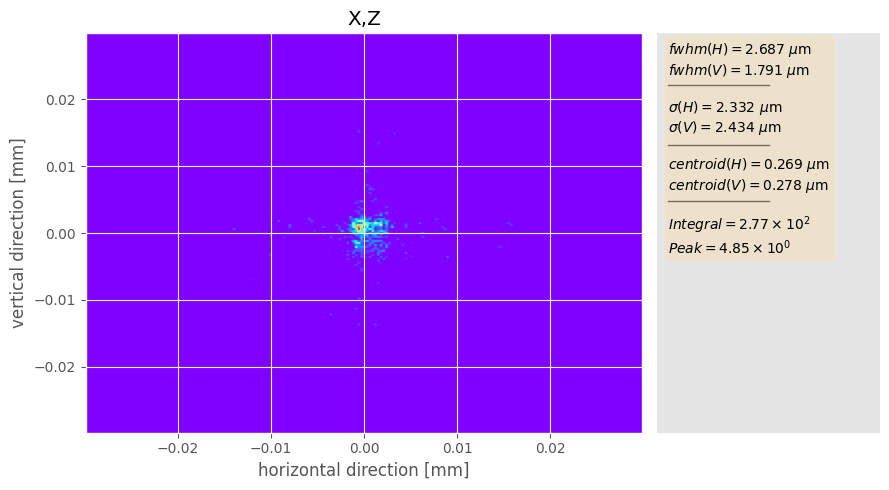

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.
[0.0003402460739362589, 0.0033923839367220312]


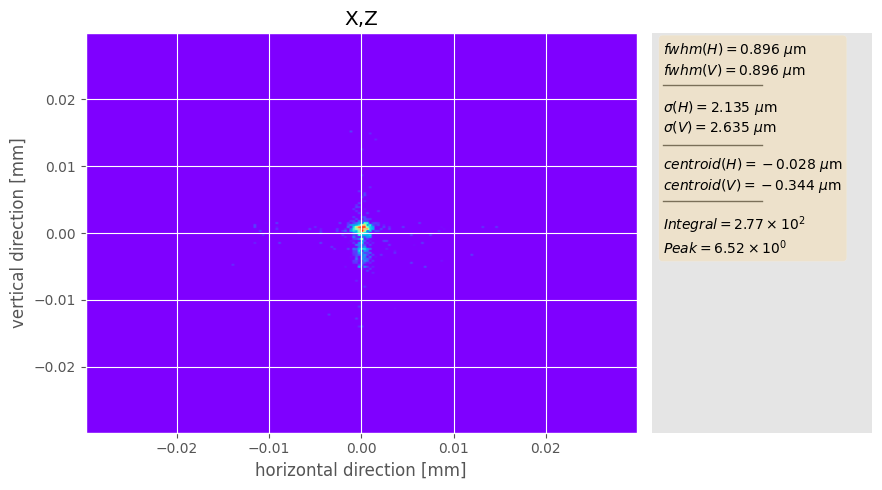

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.
[0.0008818780069398018, 0.0027253386814622433]


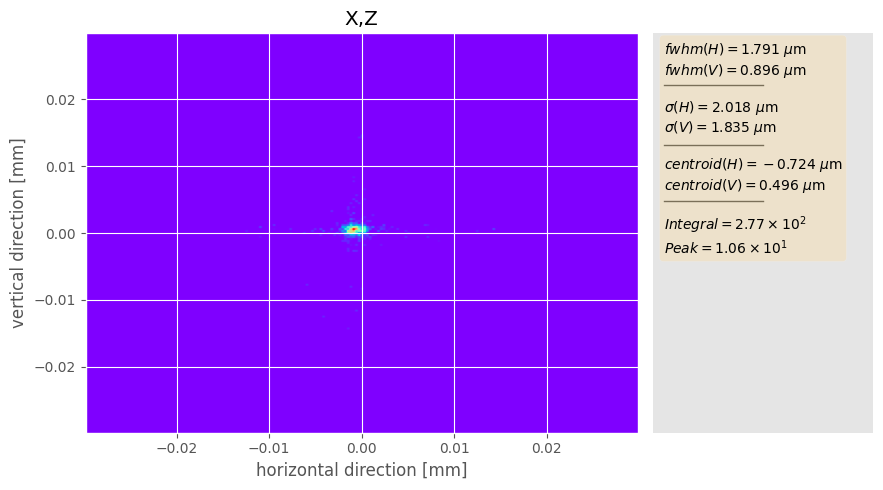

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.
[0.0008674661816080307, 0.003042551906575605]


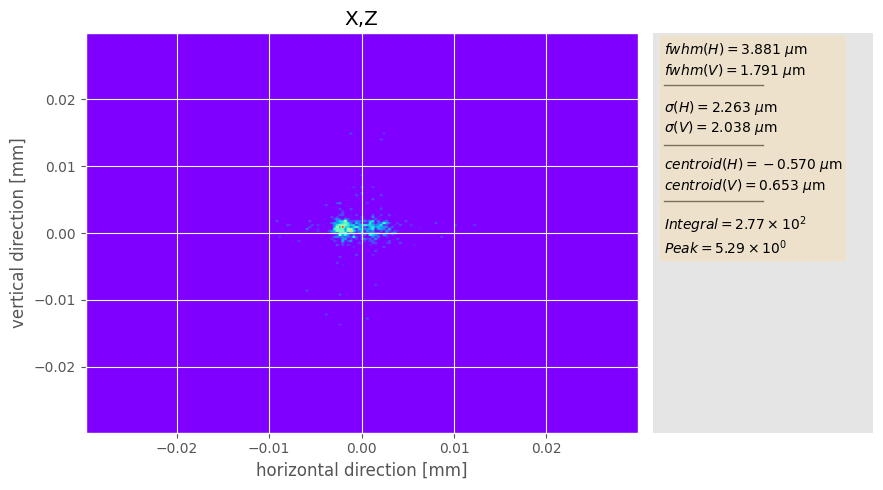

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.
[0.00323827628455978, 0.002609367362614611]


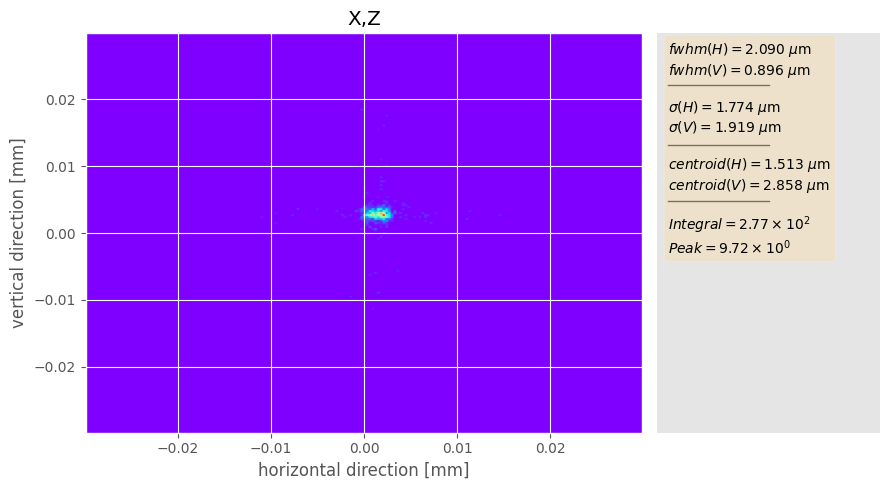

In [152]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values)
    plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)

In [153]:
opt_trial.trials(100)

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-0.04, 0.038539816339744834].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:59:38,735] Trial 200 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:59:43,655] Trial 201 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:59:48,139] Trial 202 finished with values: [0.007740432600677483, 0.003456160534186666] and parameters: {'hkb_1': -26.267300000000002, 'vkb_1': -35.3843, 'hkb_2': 47.75609999999999, 'vkb_2': -24.1456, 'hkb_3': 0.003633231299858236, 'vkb_3': 0.026322511575784517, 'hkb_4': 26.5, 'vkb_4': 0.20000000000000284}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 23:59:53,332] Trial 203 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-09-24 23:59:58,337] Trial 204 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: Th

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:00:04,053] Trial 205 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:00:09,910] Trial 206 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:00:13,722] Trial 207 finished with values: [0.006994335411076786, 0.0028665454437004135] and parameters: {'hkb_1': -47.7324, 'vkb_1': -16.9865, 'hkb_2': 42.422, 'vkb_2': 49.59219999999999, 'hkb_3': -0.022546707480056705, 'vkb_3': 0.015850536063818546, 'hkb_4': 23.0, 'vkb_4': 1.7000000000000028}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.ap

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:00:18,048] Trial 208 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-09-25 00:00:22,513] Trial 209 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: Th

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:00:26,924] Trial 210 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:00:31,914] Trial 211 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:00:36,734] Trial 212 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-09-25 00:00:41,538] Trial 213 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: Th

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:00:46,888] Trial 214 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:00:52,361] Trial 215 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:00:57,049] Trial 216 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:01:01,311] Trial 217 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:01:06,113] Trial 218 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-09-25 00:01:11,765] Trial 219 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: Th

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-09-25 00:01:16,477] Trial 220 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: Th

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-09-25 00:01:20,912] Trial 221 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: Th

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:01:25,659] Trial 222 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:01:30,276] Trial 223 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:01:35,609] Trial 224 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:01:39,768] Trial 225 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:01:44,438] Trial 226 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:01:49,502] Trial 227 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:01:55,218] Trial 228 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:01:59,019] Trial 229 finished with values: [0.002015650166574643, 0.0029106657324132926] and parameters: {'hkb_1': -41.456, 'vkb_1': -11.286200000000001, 'hkb_2': 39.3638, 'vkb_2': 44.95739999999999, 'hkb_3': -0.03476401224401701, 'vkb_3': 0.019341194567807203, 'hkb_4': 24.800000000000004, 'vkb_4': 8.300000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/A

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:02:02,969] Trial 230 finished with values: [0.01653199289429134, 0.003717516251152518] and parameters: {'hkb_1': 6.635499999999993, 'vkb_1': 24.615099999999998, 'hkb_2': 44.376599999999996, 'vkb_2': 48.485399999999984, 'hkb_3': -0.03825467074800567, 'vkb_3': -0.008584073464102067, 'hkb_4': 26.800000000000004, 'vkb_4': 3.8000000000000043}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999]

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:02:07,777] Trial 231 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:02:12,522] Trial 232 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:02:17,240] Trial 233 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:02:22,630] Trial 234 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:02:27,680] Trial 235 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:02:34,618] Trial 236 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:02:39,452] Trial 237 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:02:44,159] Trial 238 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:02:49,058] Trial 239 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:02:53,635] Trial 240 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:02:58,498] Trial 241 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:03:03,520] Trial 242 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-09-25 00:03:09,289] Trial 243 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: Th

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:03:14,199] Trial 244 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:03:19,789] Trial 245 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:03:24,535] Trial 246 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:03:29,777] Trial 247 finished with values: [0.01903391775174497, 0.0027902394151377605] and parameters: {'hkb_1': 0.8898999999999972, 'vkb_1': -24.112600000000004, 'hkb_2': -5.3419000000000025, 'vkb_2': 37.26029999999999, 'hkb_3': 0.033303828583761845, 'vkb_3': 0.0245771823237902, 'hkb_4': 24.200000000000003, 'vkb_4': 11.300000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999]

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:03:34,554] Trial 248 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:03:38,993] Trial 249 finished with values: [0.017716624153324426, 0.003879495363626631] and parameters: {'hkb_1': -39.0162, 'vkb_1': -44.7159, 'hkb_2': -8.121700000000004, 'vkb_2': 35.180499999999995, 'hkb_3': -0.03825467074800567, 'vkb_3': -0.036509341496011344, 'hkb_4': 21.400000000000006, 'vkb_4': 13.800000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-09-25 00:03:44,172] Trial 250 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: Th

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:03:49,061] Trial 251 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:03:54,778] Trial 252 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:03:58,871] Trial 253 finished with values: [0.007375162533777321, 0.0034944539286521008] and parameters: {'hkb_1': -13.782400000000003, 'vkb_1': 2.4753999999999934, 'hkb_2': 46.20989999999999, 'vkb_2': 25.02109999999999, 'hkb_3': -0.04, 'vkb_3': 0.0245771823237902, 'hkb_4': 15.300000000000004, 'vkb_4': 0.8000000000000007}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.war

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:04:03,117] Trial 254 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:04:09,499] Trial 255 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:04:12,769] Trial 256 finished with values: [0.0025095657201744605, 0.0026980180884307757] and parameters: {'hkb_1': -29.4444, 'vkb_1': -33.90260000000001, 'hkb_2': 42.002399999999994, 'vkb_2': 42.778999999999996, 'hkb_3': -0.03476401224401701, 'vkb_3': 0.026322511575784517, 'hkb_4': 26.400000000000006, 'vkb_4': 2.3000000000000043}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  war

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:04:18,131] Trial 257 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-09-25 00:04:22,566] Trial 258 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: Th

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:04:26,941] Trial 259 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:04:31,779] Trial 260 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:04:36,482] Trial 261 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:04:41,629] Trial 262 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:04:46,312] Trial 263 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:04:51,558] Trial 264 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:04:56,170] Trial 265 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:04:59,967] Trial 266 finished with values: [0.0006584345664309247, 0.003425219526456579] and parameters: {'hkb_1': 39.282099999999986, 'vkb_1': 6.426099999999998, 'hkb_2': 28.949799999999996, 'vkb_2': 21.6357, 'hkb_3': -0.020801378228062377, 'vkb_3': 0.0245771823237902, 'hkb_4': 28.800000000000004, 'vkb_4': 5.200000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:05:05,022] Trial 267 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:05:10,657] Trial 268 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:05:17,446] Trial 269 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:05:24,654] Trial 270 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:05:29,385] Trial 271 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:05:32,745] Trial 272 finished with values: [0.006172756853800191, 0.002821715461606193] and parameters: {'hkb_1': -21.700100000000003, 'vkb_1': -30.0625, 'hkb_2': 31.260499999999993, 'vkb_2': 24.5809, 'hkb_3': -0.03825467074800567, 'vkb_3': 0.02806784082777885, 'hkb_4': 29.5, 'vkb_4': 2.1000000000000014}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/O

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:05:37,413] Trial 273 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:05:43,090] Trial 274 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:05:46,685] Trial 275 finished with values: [0.0011720671996304586, 0.002798663612257073] and parameters: {'hkb_1': 8.332399999999993, 'vkb_1': -12.110000000000007, 'hkb_2': 32.01929999999999, 'vkb_2': 43.98379999999999, 'hkb_3': -0.022546707480056705, 'vkb_3': 0.019341194567807203, 'hkb_4': 26.700000000000003, 'vkb_4': 6.800000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999]

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:05:51,887] Trial 276 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:05:56,694] Trial 277 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:06:02,309] Trial 278 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:06:07,003] Trial 279 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:06:12,846] Trial 280 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:06:17,266] Trial 281 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:06:21,917] Trial 282 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:06:27,812] Trial 283 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:06:32,588] Trial 284 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:06:37,619] Trial 285 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:06:42,595] Trial 286 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-09-25 00:06:46,927] Trial 287 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: Th

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:06:51,877] Trial 288 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:06:56,291] Trial 289 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:07:01,286] Trial 290 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:07:05,845] Trial 291 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:07:10,348] Trial 292 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:07:16,452] Trial 293 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:07:21,572] Trial 294 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:07:25,077] Trial 295 finished with values: [0.0010873708141237036, 0.0029258394043553053] and parameters: {'hkb_1': 12.397099999999995, 'vkb_1': -19.7693, 'hkb_2': 47.949499999999986, 'vkb_2': 45.1699, 'hkb_3': -0.026037365984045366, 'vkb_3': 0.03504915783575618, 'hkb_4': 25.700000000000003, 'vkb_4': -0.6999999999999993}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:07:30,060] Trial 296 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:07:34,556] Trial 297 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:07:39,527] Trial 298 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 00:07:44,346] Trial 299 pruned. 


/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_28594/1036378160.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


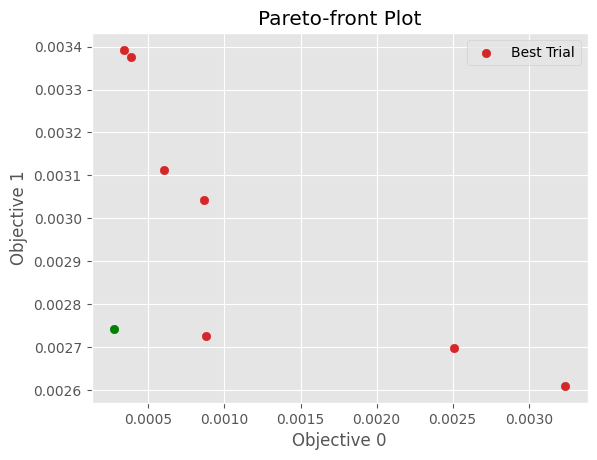

In [154]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
plt.scatter(centroid_ground, sigma_ground, color='green')

In [155]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum())

-13.191309300089534
-13.547152866907552
-13.672063833826936
-12.938619397465729
-12.844992703386975
-11.681361578515792
-11.902883377492948


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.
[0.0005995903923481749, 0.0031133826197188305]


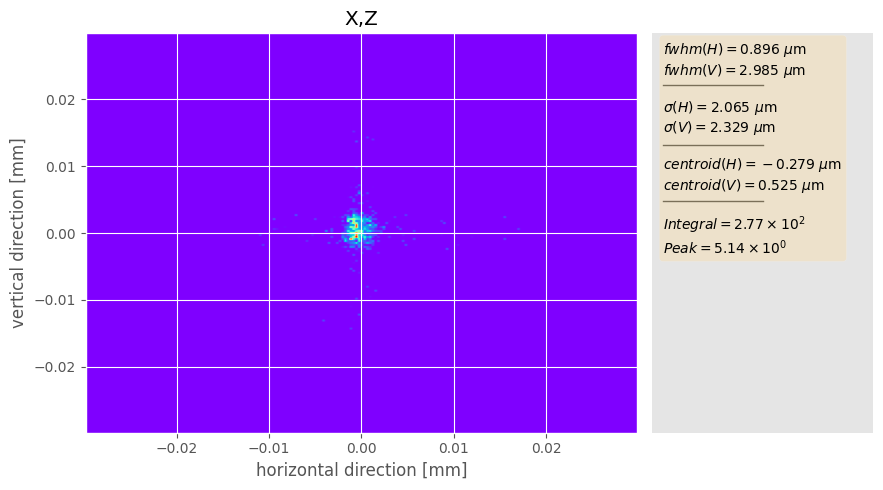

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.
[0.0003873074716109549, 0.0033766837613488903]


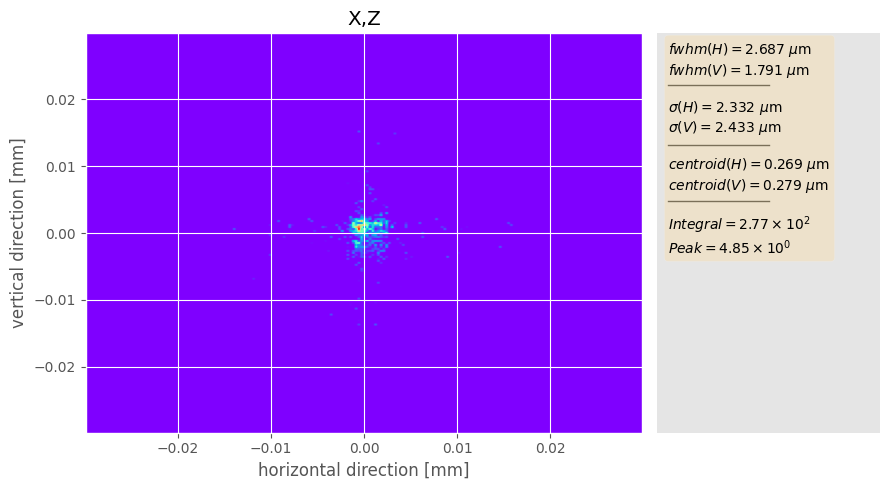

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.
[0.0003402460739362589, 0.0033923839367220312]


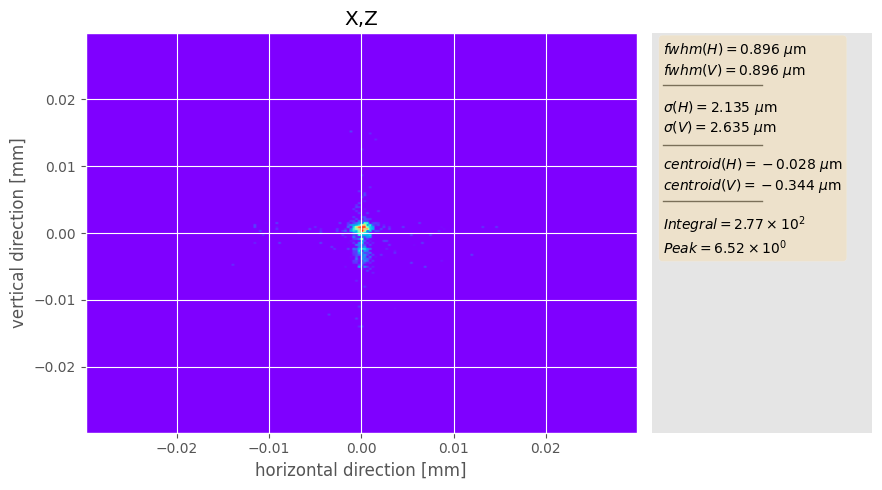

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.
[0.0008818780069398018, 0.0027253386814622433]


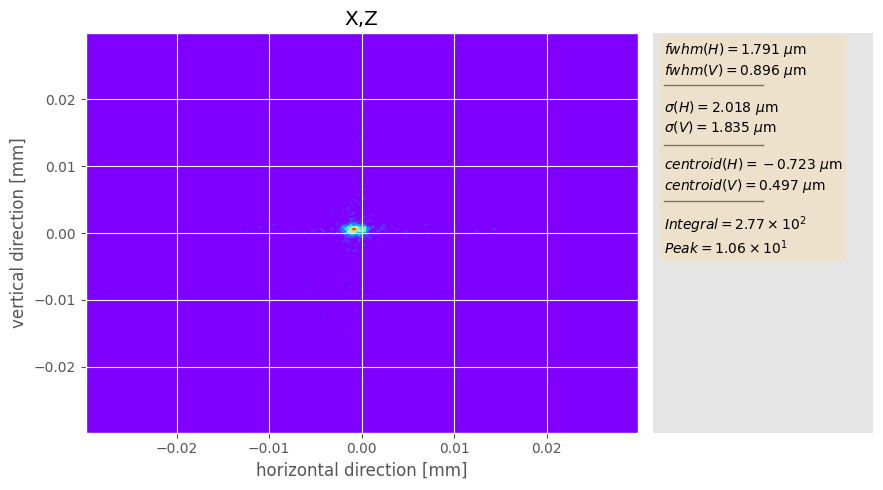

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.
[0.0008674661816080307, 0.003042551906575605]


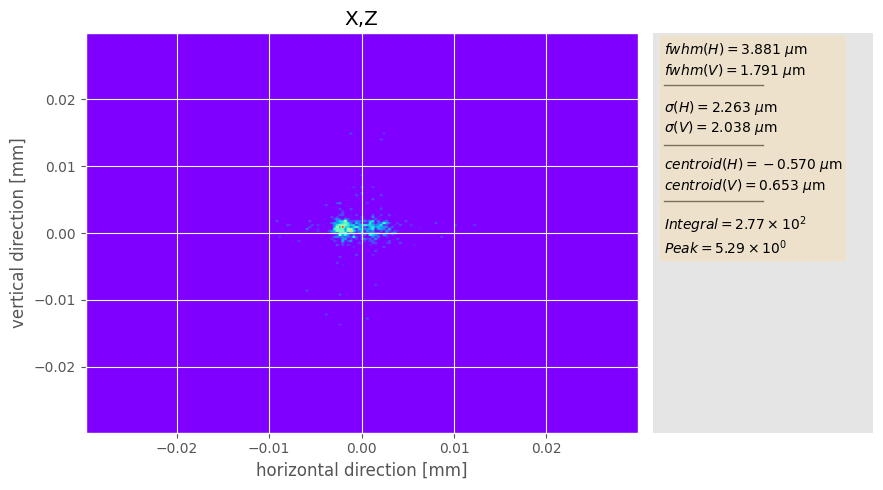

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.
[0.00323827628455978, 0.002609367362614611]


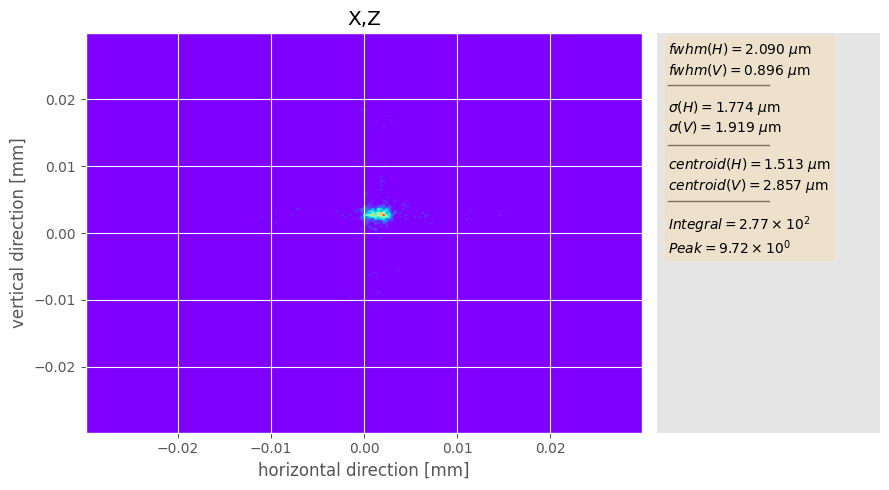

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_57793/Downstream_HKB_bender_profile.dat written to disk.
[0.0025095657201744605, 0.0026980180884307757]


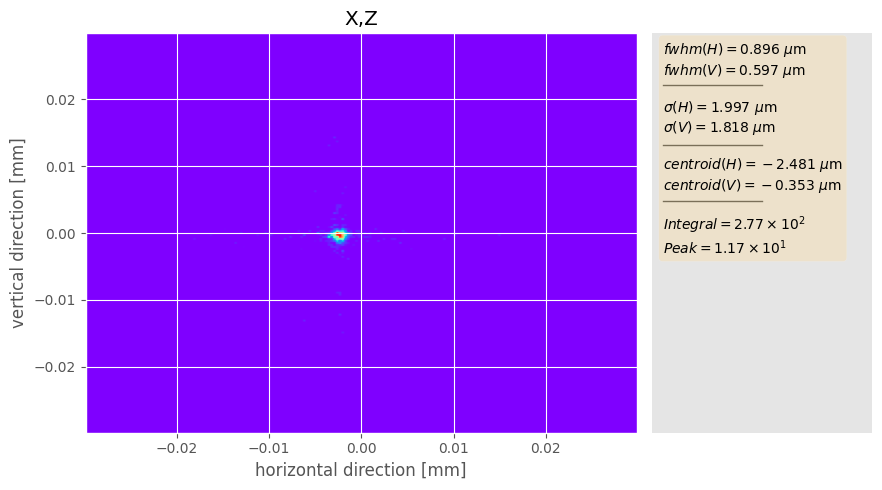

In [156]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values)
    plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)